<a href="https://colab.research.google.com/github/matthewbegun/MXN500/blob/main/MXN500_2024_LEC_12_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Refinement

In [57]:
#@title Imports
if (!require(pacman)) install.packages("pacman")
pacman::p_load(tidyverse, broom, patchwork, GGally, glue)

Loading required package: pacman



In [3]:
#@title Options
options(repr.plot.width=15, repr.plot.height=5, repr.plot.pointsize=24)

# Analysis roadmap


## Start of modelling cycle:


### 1. Explore data


### 2. Fit model


### 3. Check fit

### 4. Check assumptions


### 5. Compare models


## Return to start of cycle until satisfied


# Case study 1: Forbes and Hooker’s Alpine Pressure data.

Need: To be able to estimate atmospheric pressure (and therefore height) based
on boiling point of water.

Produce a model to satisfy the above need, considering (where relevant)
assumptions, polynomial models, interactions, transforms, etc.


## Initial model


### 1. Explore data


New names:
• `` -> `...1`
Rows: 48 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Source
dbl (5): ...1, temp, press, Pressure, Temperature

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "...1"        "temp"        "press"       "Source"      "Pressure"   
[6] "Temperature"

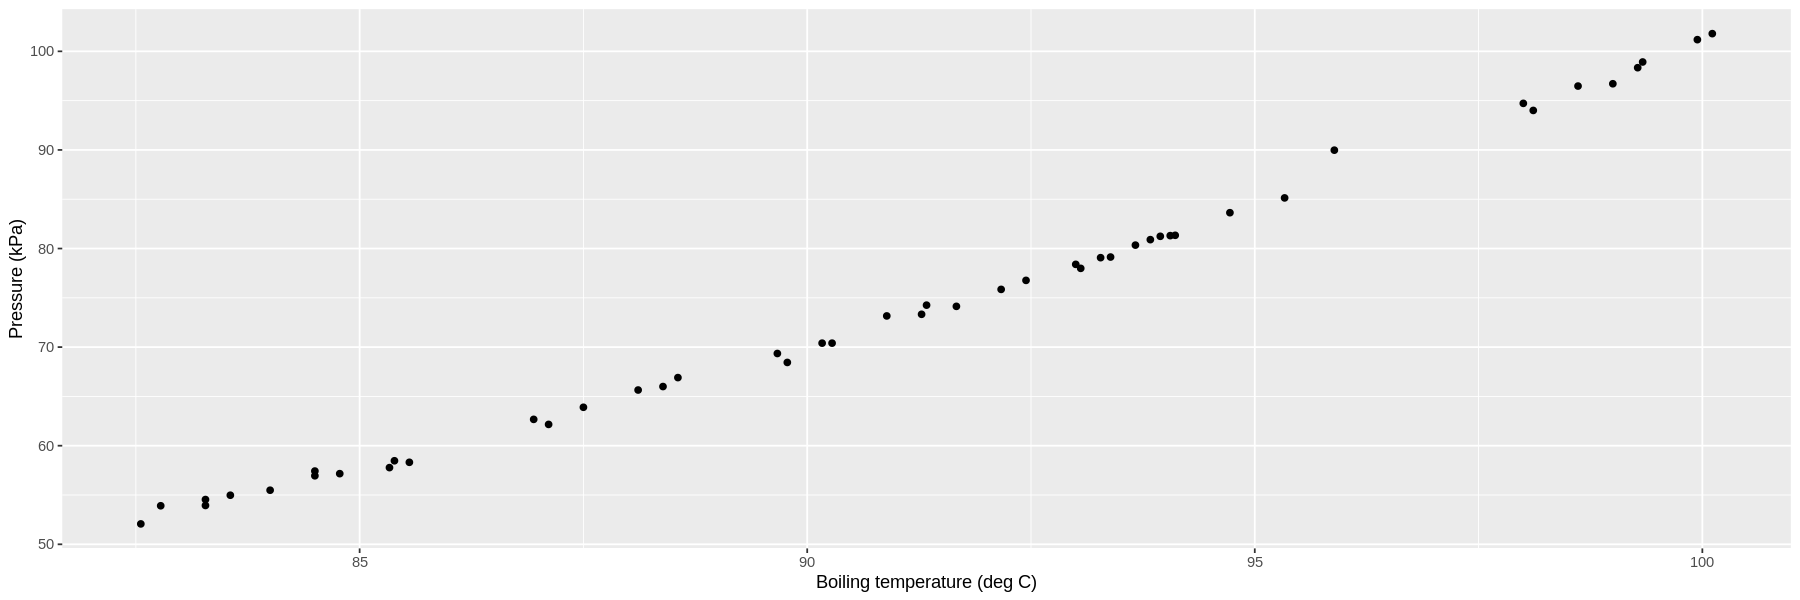

In [4]:
# Forbes' and Hooker's 48 measurements of temperature and pressure.
BP <- read_csv("https://raw.githubusercontent.com/matthewbegun/MXN500/main/data/BP.csv")
names(BP)
# Visualise:
fh <- ggplot(BP, aes(y=Pressure, x=Temperature)) +
  geom_point() +
  ylab("Pressure (kPa)") +
  xlab("Boiling temperature (deg C)")
fh

### 2. Fit model


In [5]:
BP.lm <- lm(Pressure ~ Temperature, BP)
tidy(BP.lm, conf.int=TRUE)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-177.94546,3.45534448,-51.49862,2.516784e-42,-184.900706,-170.990210
Temperature,2.76803,0.03792265,72.99147,3.288746e-49,2.691695,2.844364


### 3. Check fit

In [6]:
BP.sum <- summary(BP.lm)
glance(BP.sum)

r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.9914399,0.9912538,1.363897,5327.754,3.288746e-49,1,46,48


- Very strong linear relationship, $R^2 = 0.9914$.

- The model explains almost all the variation in Pressure, with the following model equation:
$$Pressure = -177.95 + 2.77 \times Temperature$$

### 4. Check assumptions


Joining with `by = join_by(Pressure, Temperature)`
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


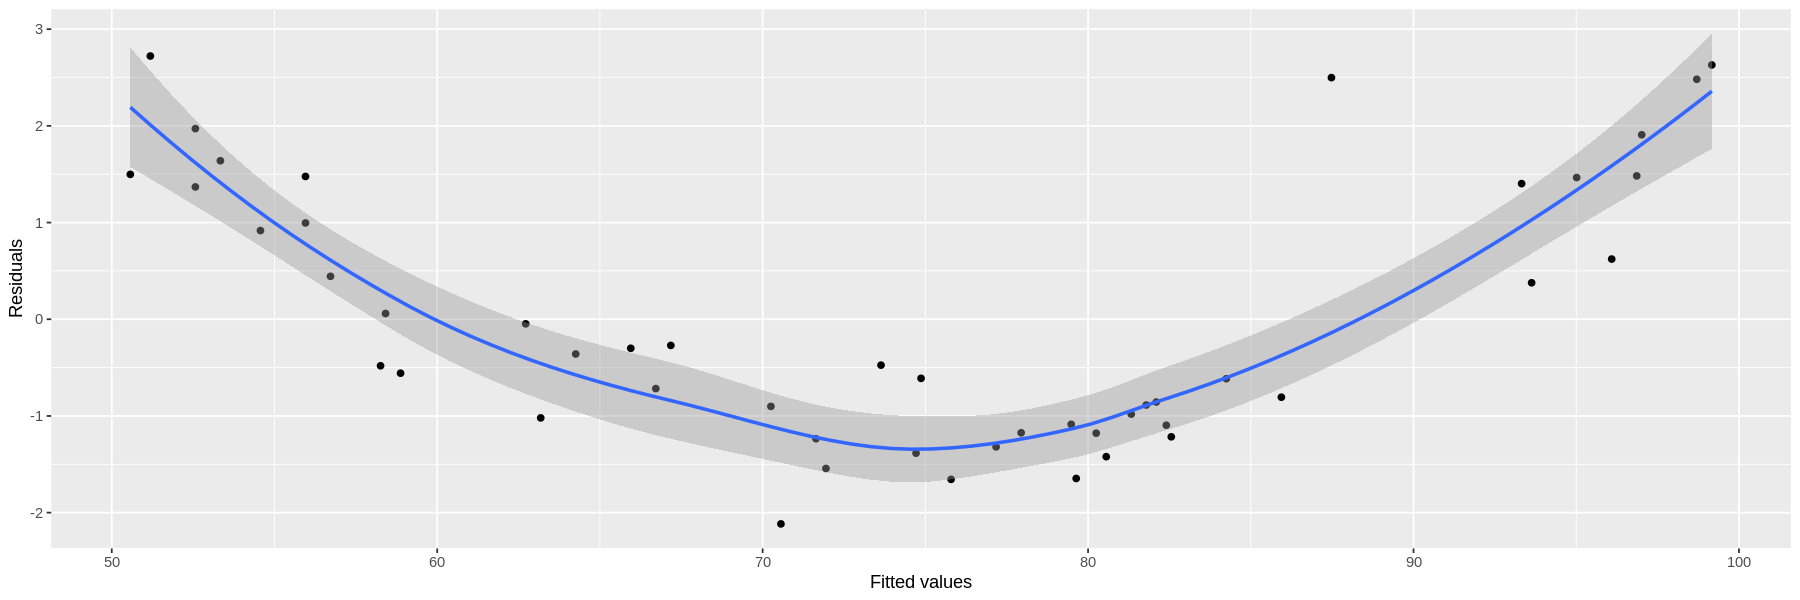

In [7]:
# Check residuals vs fitted values.
BP.fort <- fortify(BP.lm) %>%
  inner_join(., BP)

# can't use augment because we will want `Source` which isn't in the model!
# BP.fort <- augment(BP.lm)

ggplot(BP.fort, aes(x=.fitted, y=.resid)) +
  geom_point() +
  geom_smooth() +
  xlab("Fitted values") +
  ylab("Residuals")


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


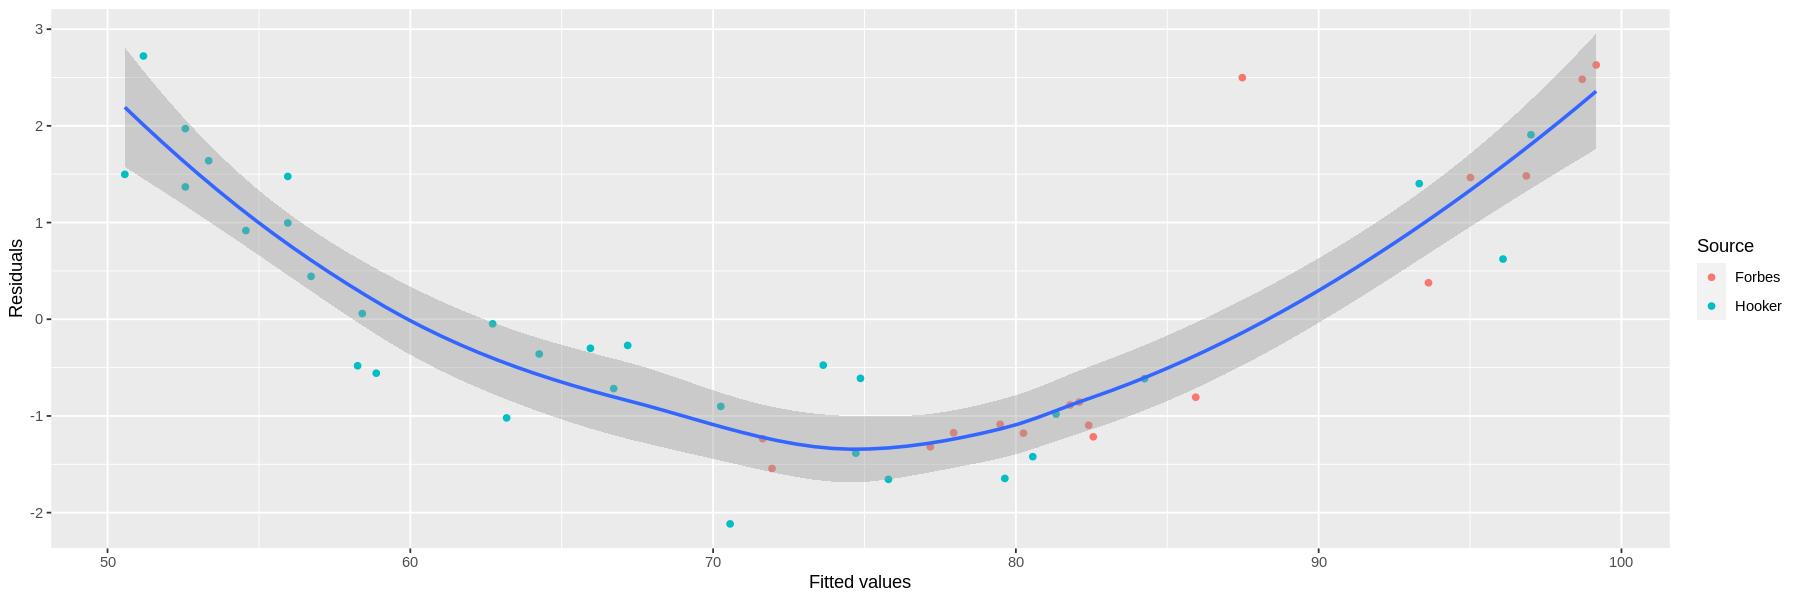

In [8]:
# Colour residuals by source (investigate potential difference in residuals).
ggplot(BP.fort, aes(x=.fitted, y=.resid)) +
  geom_point(aes(color=Source)) +
  geom_smooth() +
  xlab("Fitted values") +
  ylab("Residuals") +
  theme(legend.position="right")


- Identifiable curvature in residuals vs fitted plot.
- Seems the relationship is different for different sources, perhaps an interaction would help.


## Interaction model

### 1. Explore data

`geom_smooth()` using formula = 'y ~ x'


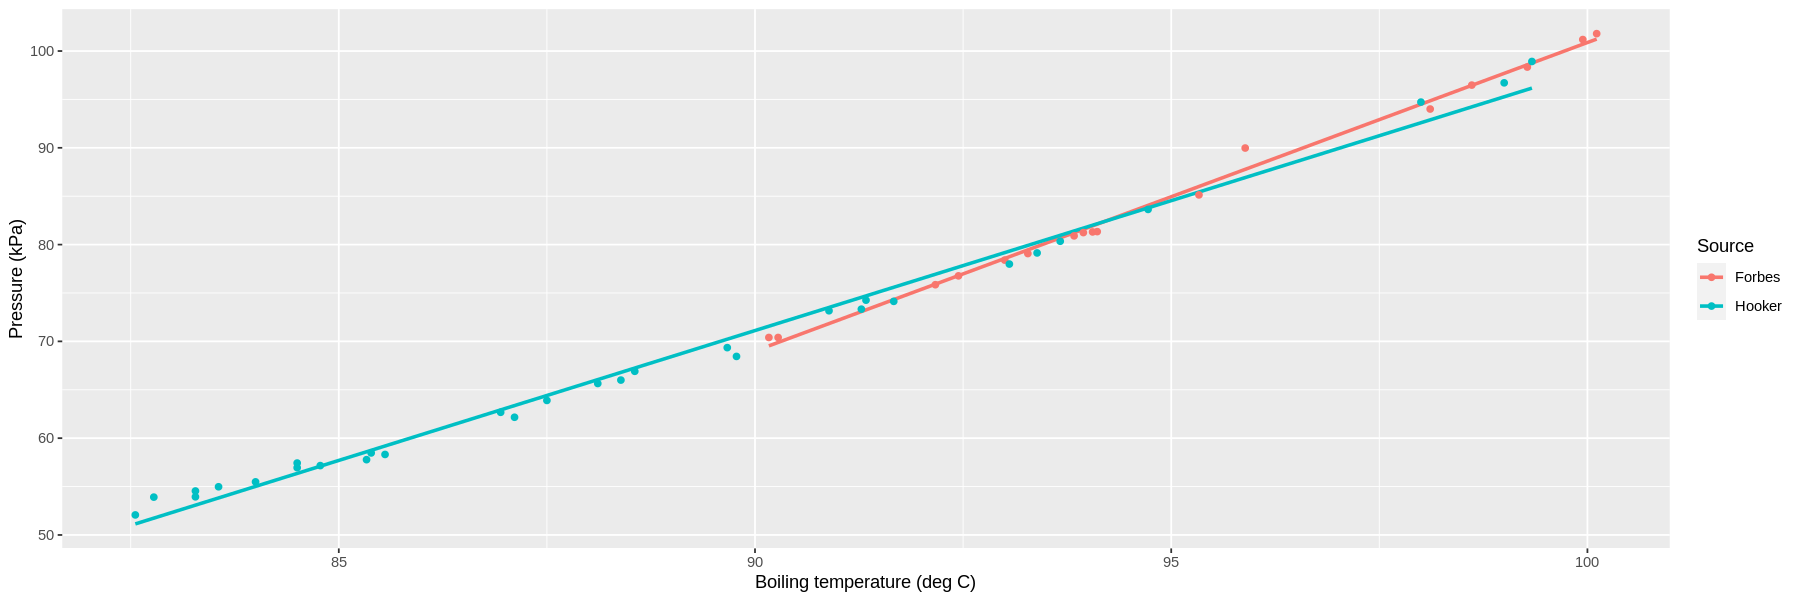

In [9]:
# Visualise:
ggplot(BP, aes(y=Pressure, x=Temperature, color=Source)) +
  geom_smooth(method="lm", se=F) +
  geom_point() +
  ylab("Pressure (kPa)") +
  xlab("Boiling temperature (deg C)")


### 2. Fit model


In [10]:
# Fit interaction model, removing intercept for interpretation.
BP.lm.int <- lm(Pressure ~ Source + Temperature:Source - 1, BP)
tidy(BP.lm.int, conf.int=T)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SourceForbes,-217.850432,8.03626712,-27.10841,4.301196e-29,-234.046464,-201.654400
SourceHooker,-170.415772,3.61852187,-47.09541,2.748152e-39,-177.708424,-163.123121
SourceForbes:Temperature,3.187292,0.08457041,37.68803,3.941007e-35,3.016851,3.357732
SourceHooker:Temperature,2.683739,0.04070374,65.93349,1.255771e-45,2.601706,2.765772


### 3. Check fit

In [11]:
glance(summary(lm(Pressure ~ Temperature*Source, BP)))
# NOTE: must include intercept to get R^2

r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.9948427,0.9944911,1.082441,2829.216,2.529999e-50,3,44,48


- Improved model fit with $R^2 = 0.9945$.
- Need to check residual vs fitted again.


### 4. Check assumptions


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


NULL

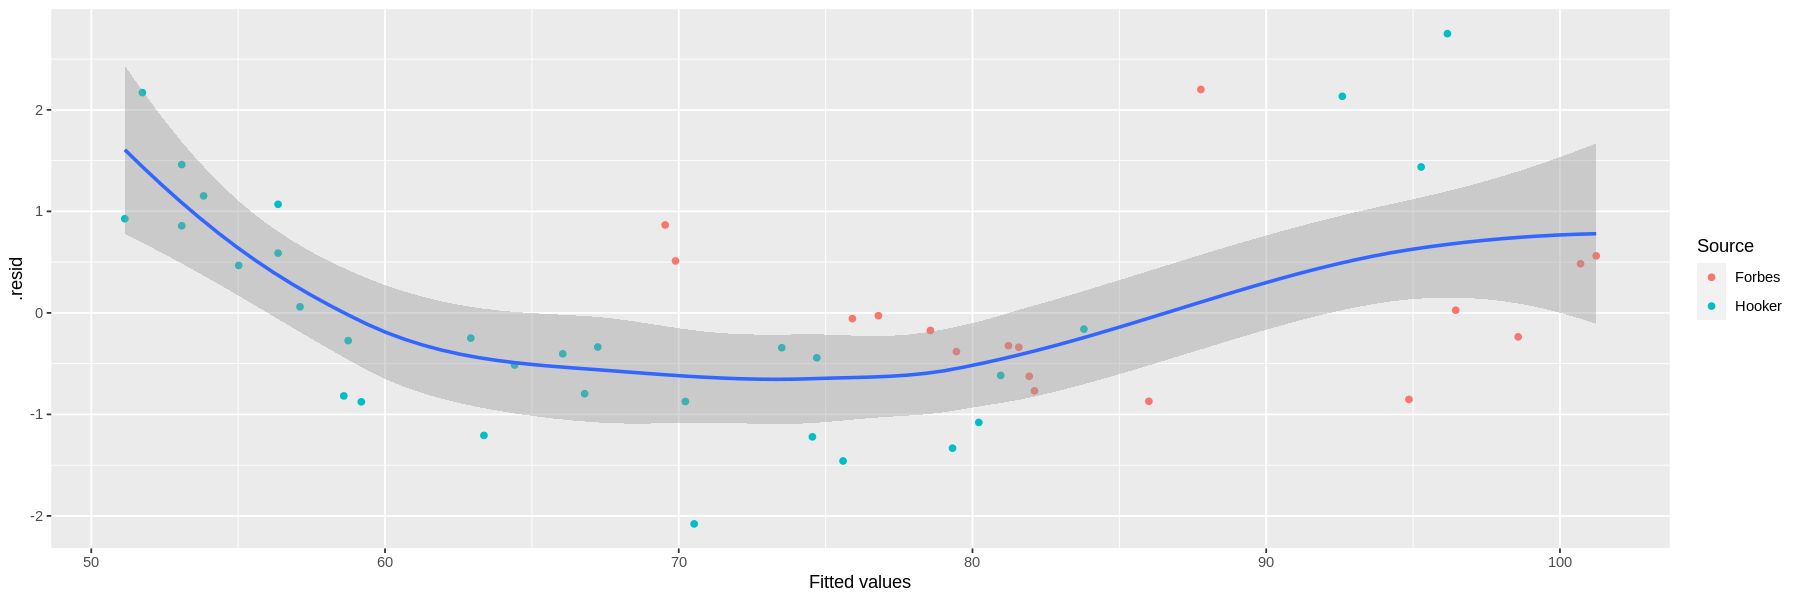

In [12]:
# Residuals vs fitted values.
# BP.fort.int <- fortify(BP.lm.int) %>%
#   inner_join(., BP)
BP.fort.int <- augment(BP.lm.int) # works now that Source is in the lm
ggplot(BP.fort.int, aes(x=.fitted, y=.resid)) +
  geom_point(aes(color=Source)) + xlab("Fitted values") +
  geom_smooth()
  ylab("Residuals") +
  theme(legend.position="right")


- Curvature still present, but not as bad.
- Perhaps due to unexplained curvature from our Temperature variable not having a linear effect on Pressure.
  - Can check this by plotting residuals vs Temperature!

## Poly model

### 1. Explore data

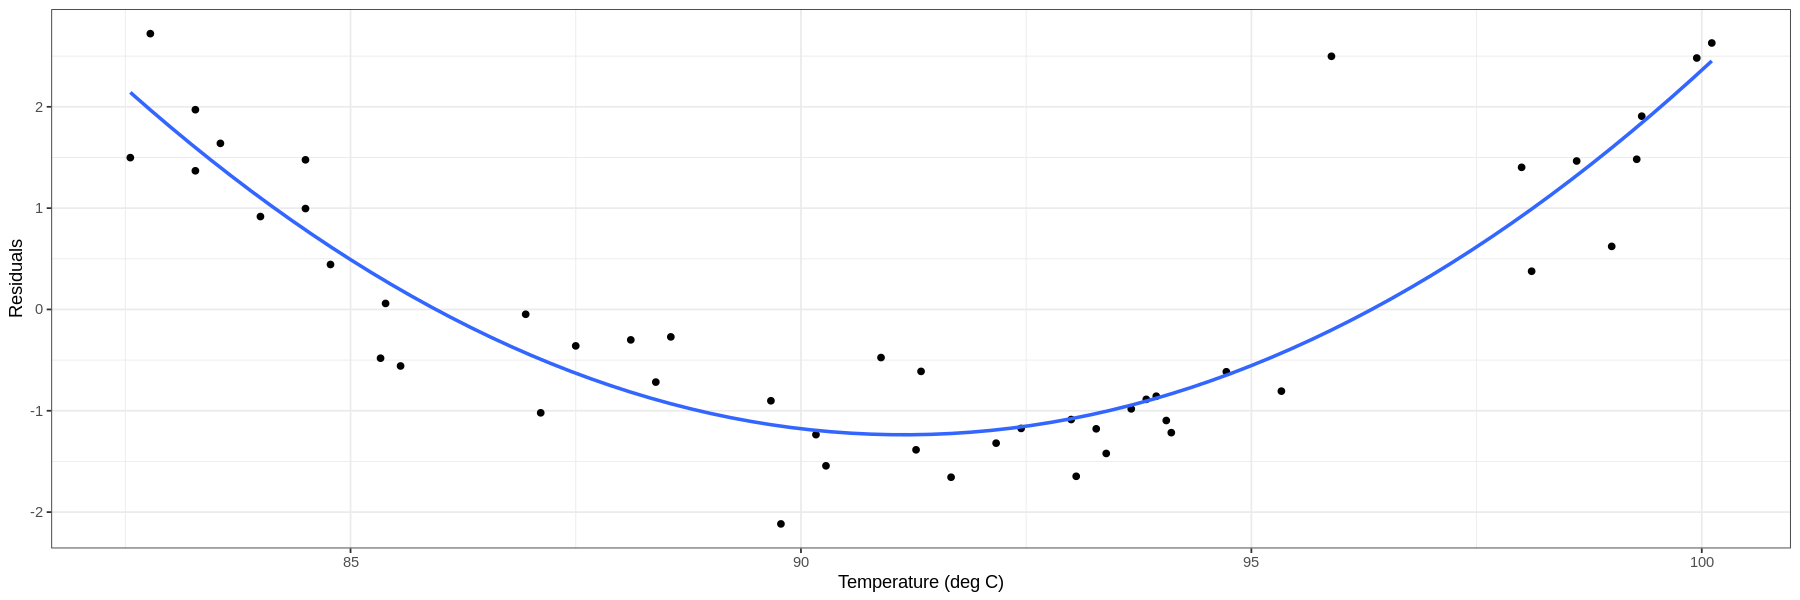

In [13]:
# First model:
ggplot(BP.fort, aes(x=Temperature, y=.resid)) +
  geom_point() + xlab("Temperature (deg C)") +
  ylab("Residuals") + theme_bw() +
  geom_smooth(method="lm", formula= y ~ poly(x,2), se=F)

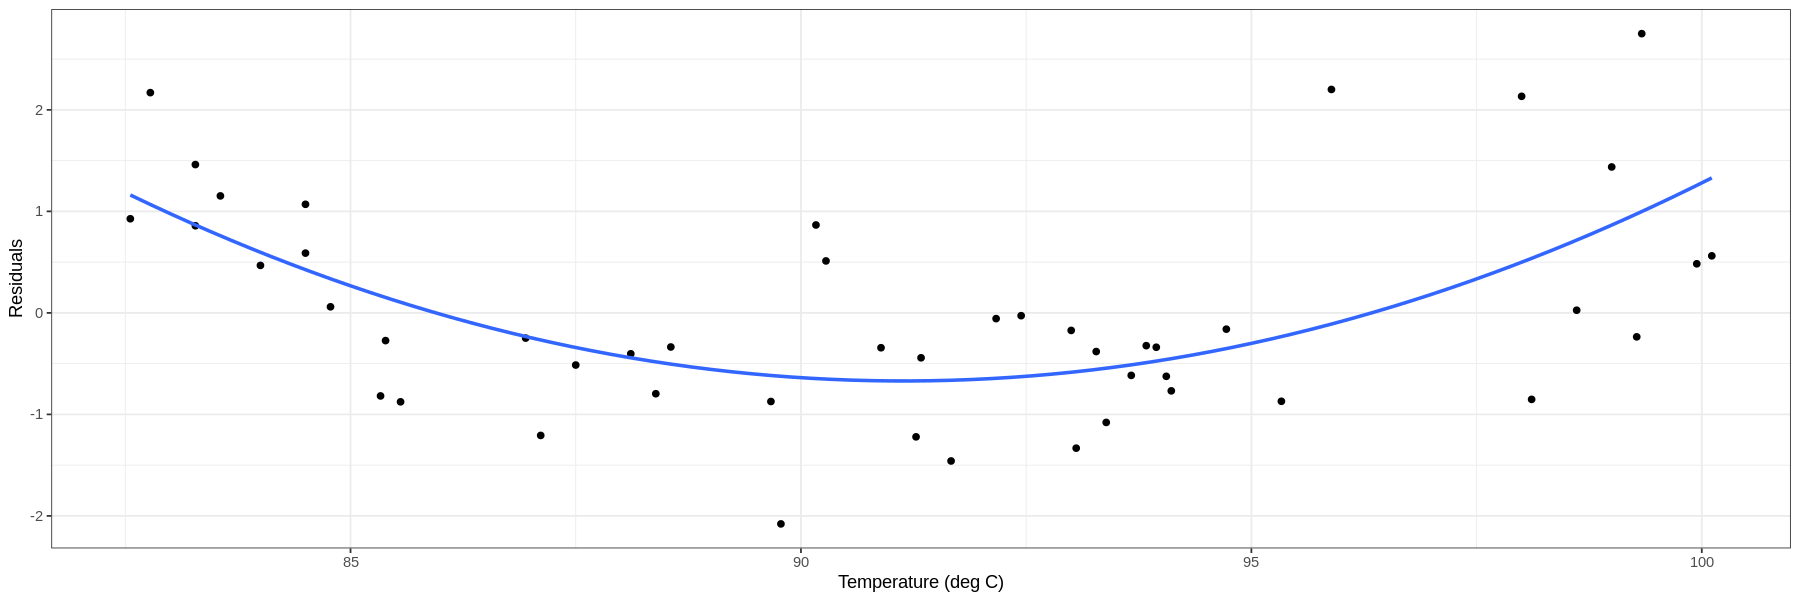

In [14]:
# Second model:
ggplot(BP.fort.int, aes(x=Temperature, y=.resid)) +
  geom_point() + xlab("Temperature (deg C)") +
  ylab("Residuals") + theme_bw() +
  geom_smooth(method="lm", formula= y ~ poly(x,2), se=F)


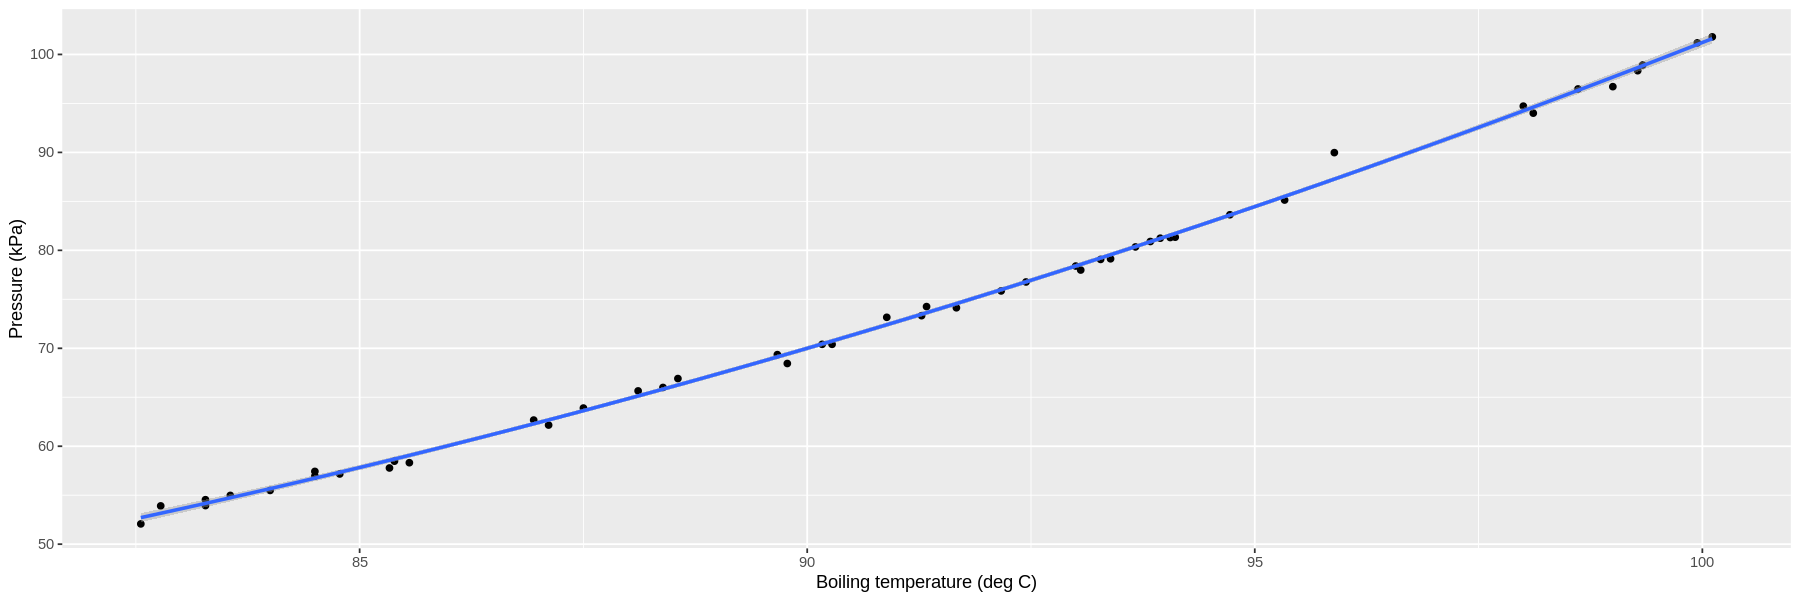

In [15]:
# Update first plot with a quadratic line of best fit.
fh + geom_smooth(method="lm", formula = y ~ poly(x,2))


### 2. Fit model


In [16]:
# Back to the start, add a polynomial term for Temperature.
BP.lm.poly <- lm(Pressure ~ poly(Temperature,2), BP)
tidy(BP.lm.poly, conf.int=T)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),73.855543,0.08740237,845.00617,3.638359e-96,73.679506,74.031581
"poly(Temperature, 2)1",99.552872,0.60554140,164.40308,3.454182e-64,98.333249,100.772495
"poly(Temperature, 2)2",8.310796,0.60554140,13.72457,1.080897e-17,7.091173,9.530419


### 3. Check fit

In [17]:
glance(summary(BP.lm.poly))

r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.9983493,0.998276,0.6055414,13608.37,2.496474e-63,2,45,48


### 4. Check assumptions


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


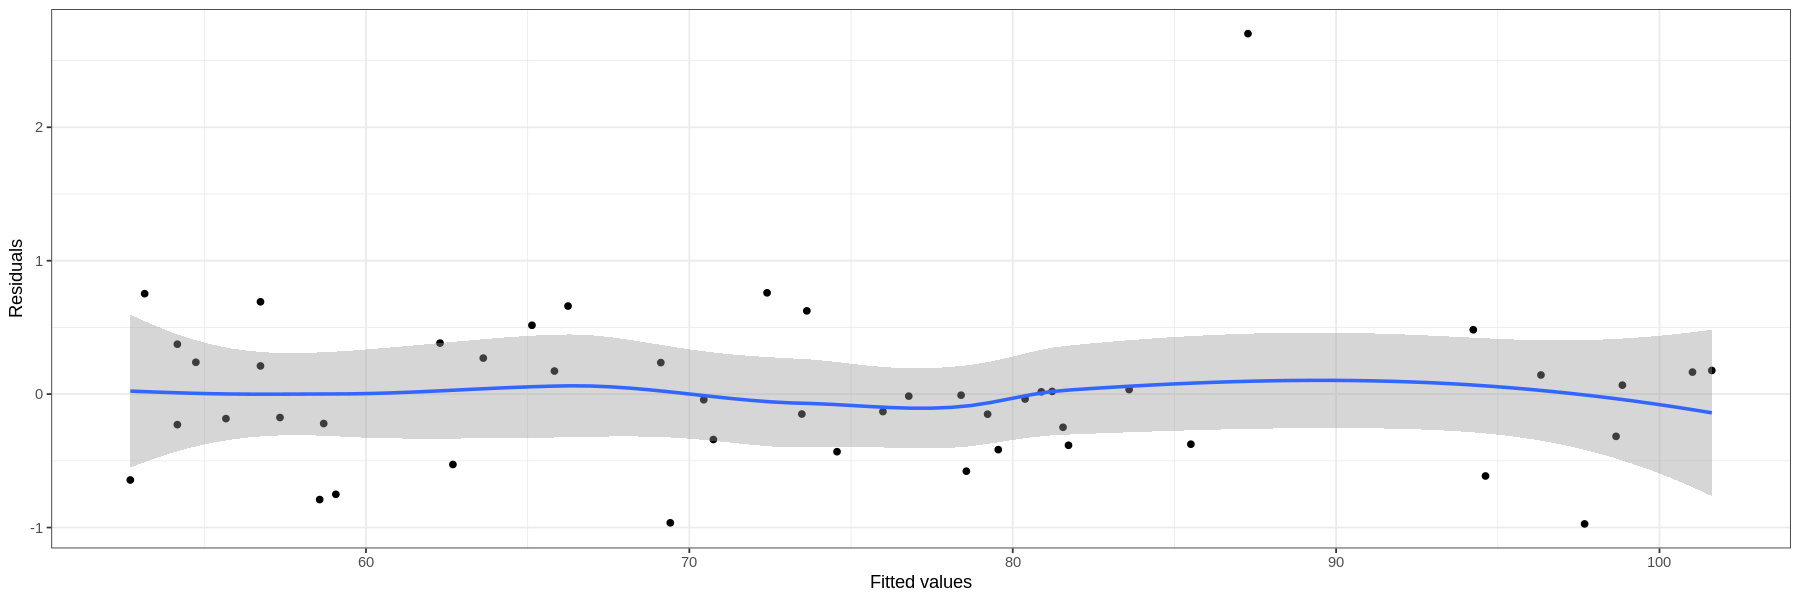

In [18]:
# Residuals vs fitted values.
# BP.fort.poly <- fortify(BP.lm.poly) %>%
#   select(.fitted, .resid, .stdresid) %>%
#   bind_cols(., BP)
BP.fort.poly <- augment(BP.lm.poly) # works here too!
ggplot(BP.fort.poly, aes(x=.fitted, y=.resid)) +
  geom_point() + geom_smooth() +
  xlab("Fitted values") +
  ylab("Residuals") + theme_bw()


- Looks much better except for a potential outlier.
- Let's test by calculating MSE!


## Outlier model

### 1. Explore data

In [19]:
# Calculate MSE:
(MSE <- mean(BP.lm.poly$residuals^2))
# Is the residual in the previous plot an outlier? Are there others?
#   Use the residual > 3*MSE check:
(outlier.rows <- which(BP.fort.poly$.resid > 3*MSE))
BP.outlier <- BP[-outlier.rows, ]

[1] 0.3437629

[1] 12

### 2. Fit model


In [20]:
# remove outlier and try again
BP.lm.poly.outlier <- lm(Pressure ~ poly(Temperature,2),BP.outlier)
tidy(BP.lm.poly.outlier, conf.int=T)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),73.512547,0.0655896,1120.79583,1.132952e-99,73.380360,73.644734
"poly(Temperature, 2)1",98.243897,0.4496596,218.48503,1.952268e-68,97.337668,99.150127
"poly(Temperature, 2)2",8.376967,0.4496596,18.62957,1.694556e-22,7.470738,9.283196


### 3. Check fit

In [21]:
glance(summary(BP.lm.poly.outlier))

r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.9990857,0.9990442,0.4496596,24041.39,1.391397e-67,2,44,47


### 4. Check assumptions


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


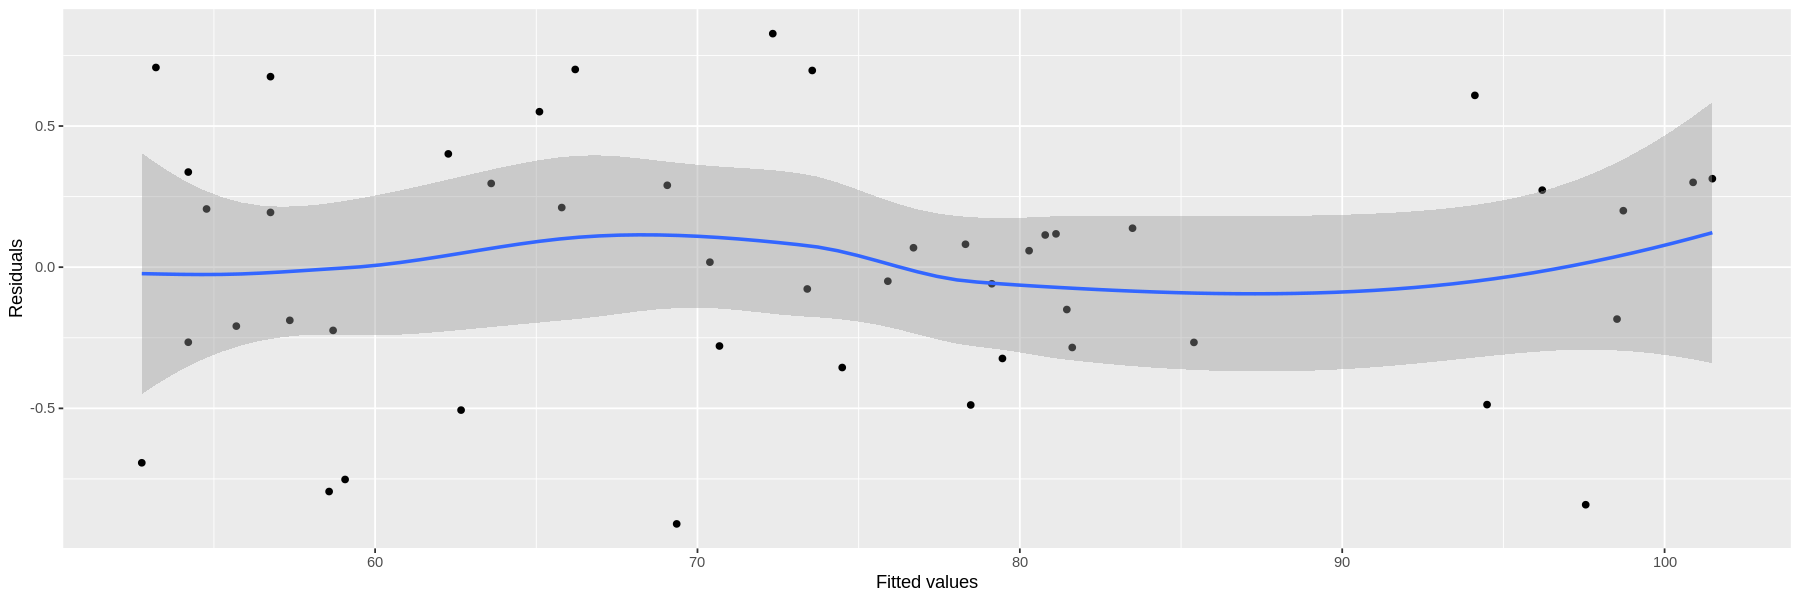

In [22]:
# Assumption plot without outlier:
BP.fort.poly.outlier <- augment(BP.lm.poly.outlier)
ggplot(BP.fort.poly.outlier, aes(x=.fitted, y=.resid)) +
  geom_point() + xlab("Fitted values") +
  ylab("Residuals") + geom_smooth()

- Looks much better!
  - No extreme residuals.
  - Fairly constant variance.


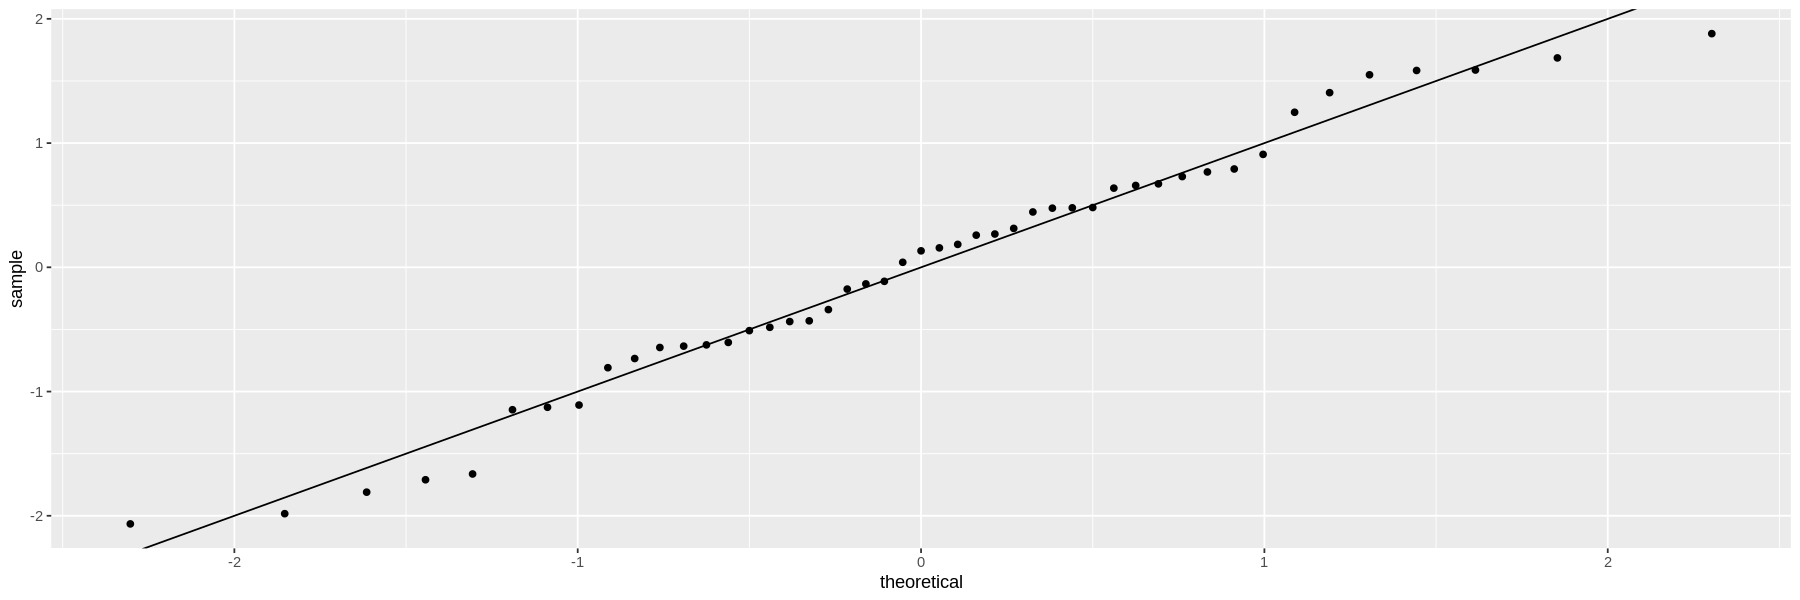

In [23]:
# Normality?
ggplot(data = BP.fort.poly.outlier, aes(sample = .std.resid)) +
geom_qq() +
geom_abline()

- Looks to be normally distributed.

### 5. Compare models


In [24]:
# Compare linear model to polynomial model (with outlier removed):
BP.lm.outlier <- lm(Pressure ~ Temperature, BP.outlier)
anova(BP.lm.outlier, BP.lm.poly.outlier)


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,45,79.070102,NA,NA,NA,NA
2,44,8.896526,1,70.17358,347.061,1.694556e-22


- p-value less than 0.05, so our polynomial model explains significantly more
variability in Pressure than the straight line model.
- How about a comparison between the polynomial model and a more complex model
with interactions!


In [25]:
BP.lm.poly.int.outlier <- lm(Pressure ~ poly(Temperature,2)*Source, BP.outlier)
anova(BP.lm.poly.outlier, BP.lm.poly.int.outlier)


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,44,8.896526,NA,NA,NA,NA
2,41,8.710817,3,0.1857092,0.2913648,0.8313767


- p-value greater than 0.05.
- Our interaction polynomial model explains slightly more of the variability,
but not so much so that the interaction is necessary.
- Can we achieve better results using a transform?

## Log transform model

### 1. Explore data


How about a log transform of the outcome variable? i.e. a model of the form:

$$
\hat{y} ∝ e^x
$$

Which translates to:

$$
\ln(y_i) = β_0 + β_1 x_i + ε_i
$$

or

$$
\begin{align*}
y_i = e^{β_0} × e^{β_1x_i} × e^{ ε_i } \\
y_i = e^{β_0} × (e^{x_i})^{β_1} × e^{ ε_i }
\end{align*}
$$

NOTE: Have to be extra careful interpreting the coefficients and errors of this model!

### 2. Fit model


In [26]:
# Model:
tidy(BP.lm.log <- lm(log(Pressure) ~ Temperature, BP.outlier), conf.int=T)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.87658720,0.0178234544,49.18167,9.178397e-41,0.8406889,0.91248548
Temperature,0.03743984,0.0001958378,191.17782,3.924169e-67,0.0370454,0.03783428


### 3. Check fit

In [27]:
glance(summary(BP.lm.log))

r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.9987703,0.998743,0.006975688,36548.96,3.924169e-67,1,45,47


### 4. Check assumptions


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


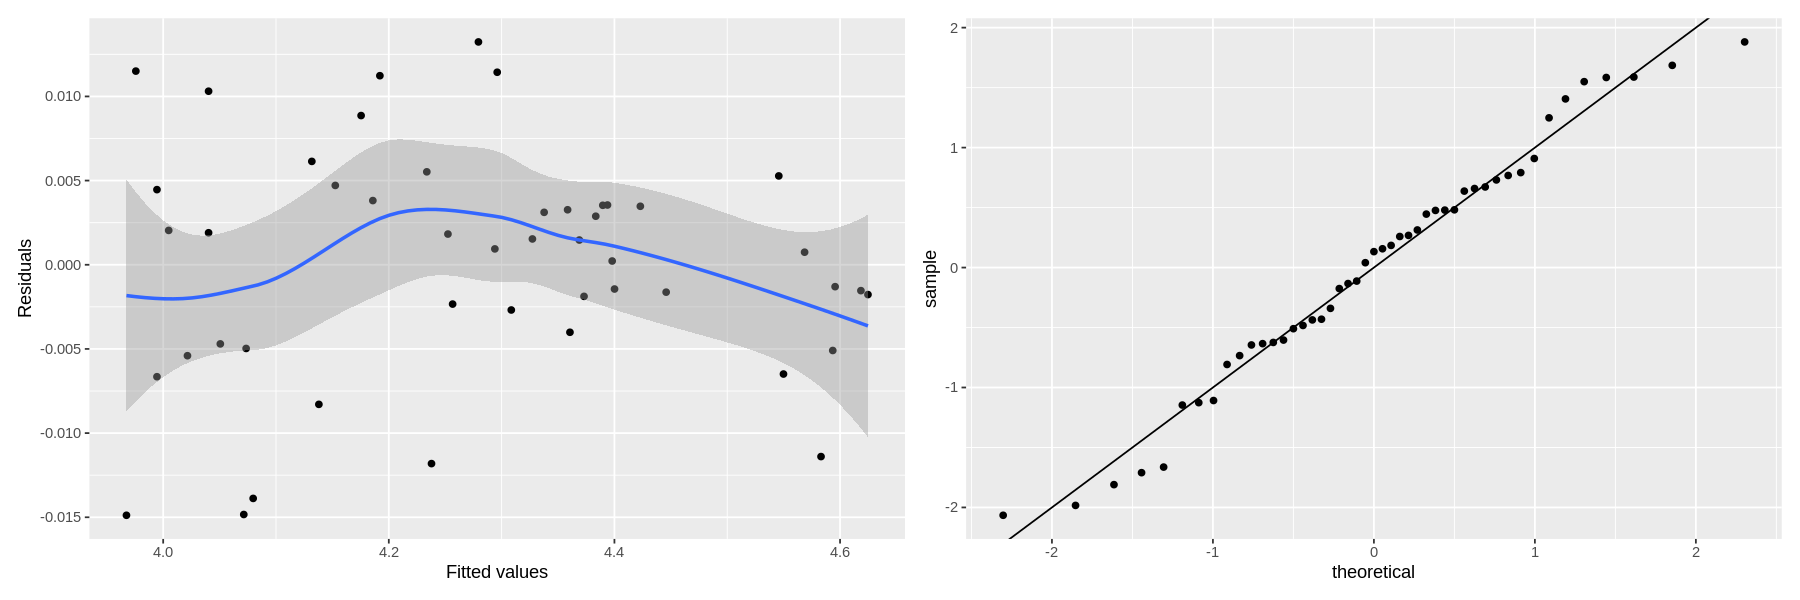

In [28]:
BP.fort.log <- augment(BP.lm.log)

g1 <- ggplot(BP.fort.log, aes(x=.fitted, y=.resid)) +
    geom_point() + geom_smooth() +
    xlab("Fitted values") + ylab("Residuals")
g2 <- ggplot(data = BP.fort.poly.outlier, aes(sample = .std.resid)) +
    geom_qq() + geom_abline()

g1 + g2 # patchwork



- Quite similar to residuals from the polynomial.
  - Residuals are smaller in scale due to transform of y.
  - Quantiles of residuals are very similar.
  - Looks like a good model fit.

### 5. Compare models


- So, which one should we use?
- Could argue that the exponential model is based on a physical law.
- Fit of exponential model is almost identical to quadratic, but with one fewer parameter.
- Cannot compare directly with F test due to log transform (models not nested).
- Probably fine to use quadratic given similar fit!
  - Just be careful extrapolating and reapplying to physical context.


# Case study 2:  Brain-body weight data.


Need: Biological allometry is the study of the relationship between size and
shape among components of living organisms. In this case study, the log of brain
weight is thought to be associated with the log of body weight.

Note: We are looking at a loglog model of the form:

$$
\hat{y} ∝ x^{β_1}
$$

Which translates to:

$$
\ln(y_i) = β_0 + β_1 \ln(x_i) + ε_i
$$

or

$$
y_i = e^{β_0} × x_i^{β_1} × e^{ ε_i }
$$


NOTE: Have to be extra *extra* careful interpreting the coefficients and errors of this model!

Produce a model to satisfy the above need, considering (where relevant)
assumptions, polynomial models, interactions, transforms, etc.


## Initial model

Rows: 27 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Species, Order, Era
dbl (2): Body, Brain

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`geom_smooth()` using formula = 'y ~ x'


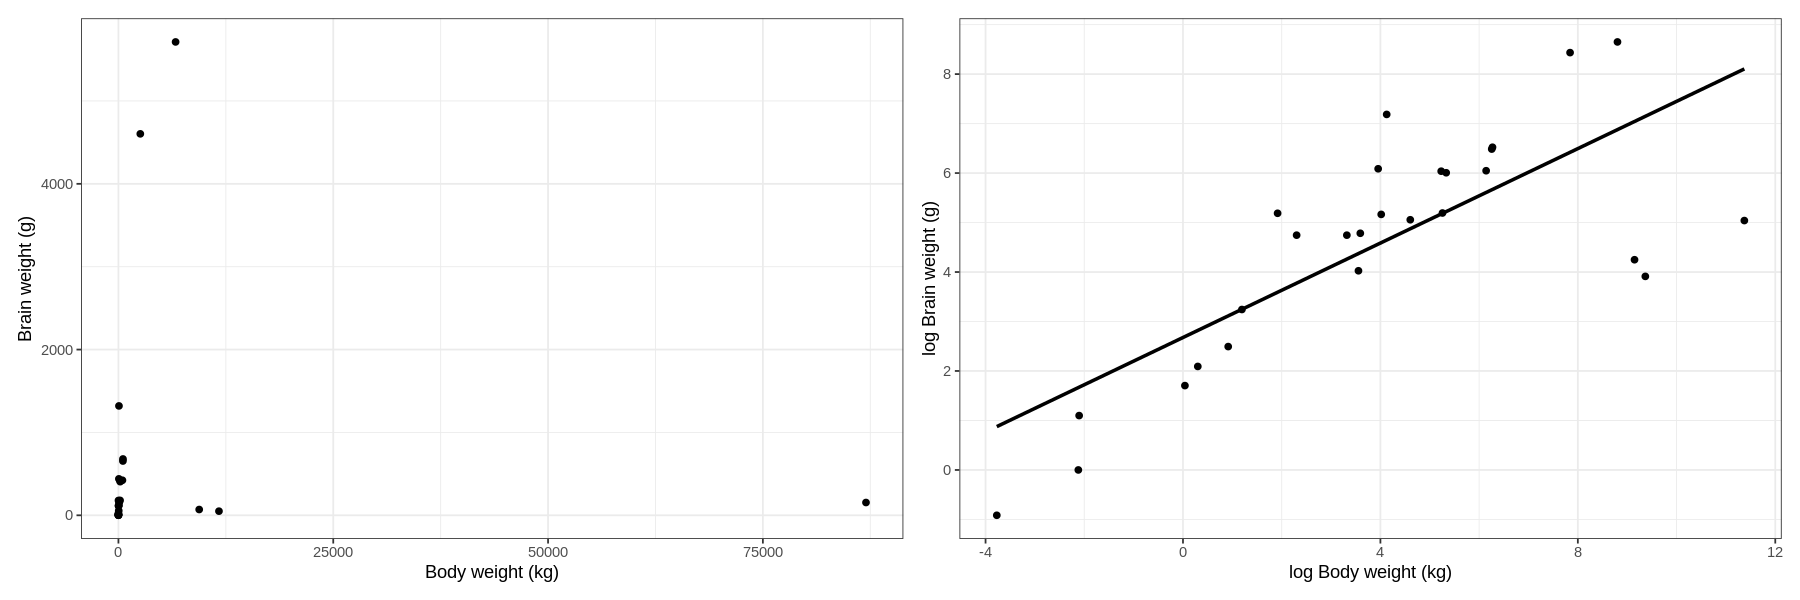

In [29]:
animals <- read_csv("https://raw.githubusercontent.com/matthewbegun/MXN500/main/data/animals.csv")
# Visual:
a1 <- ggplot(animals, aes(x=Body, y=Brain)) +
  geom_point() +
  theme_bw() +
  xlab("Body weight (kg)") +
  ylab("Brain weight (g)")
a2 <- ggplot(animals, aes(x=log(Body), y=log(Brain))) +
  geom_point() +
  theme_bw() +
  xlab("log Body weight (kg)") +
  ylab("log Brain weight (g)") +
  geom_smooth(method="lm", se=F, col="black")
a1 + a2

In [30]:
# Fit model:
bb.lm <- lm(log(Brain) ~ log(Body), animals)
tidy(bb.lm, conf.int=T)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.6765982,0.43743025,6.118914,2.139782e-06,1.7756937,3.5775026
log(Body),0.4772406,0.08135884,5.865873,4.048825e-06,0.3096789,0.6448023


In [31]:
glance(summary(bb.lm))

r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.5791845,0.5623519,1.538295,34.40846,4.048825e-06,1,25,27


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


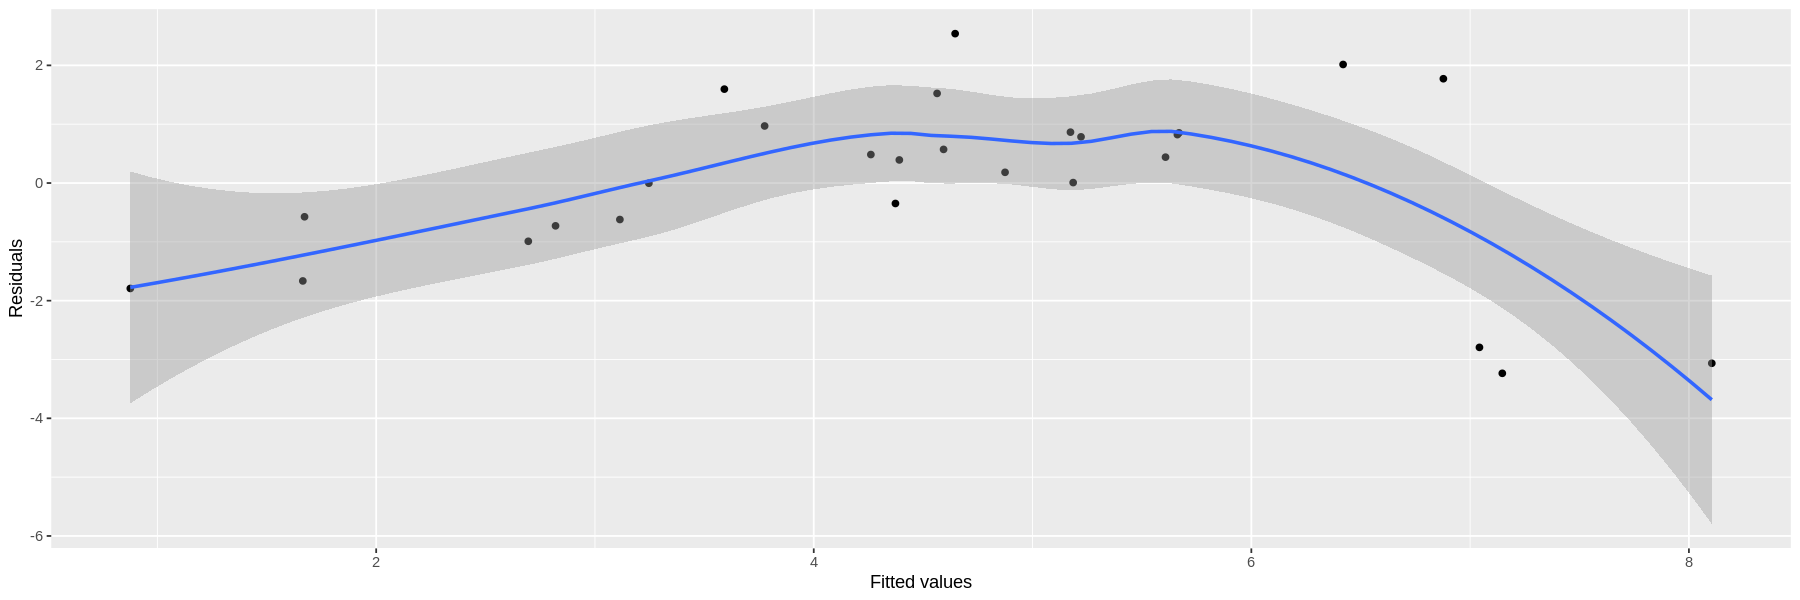

In [32]:
# Check residual vs fitted:
bb.fort <- fortify(bb.lm) %>%
  bind_cols(animals)
ggplot(bb.fort, aes(y=.resid, x=.fitted)) +
  geom_point() + geom_smooth() +
  xlab("Fitted values") + ylab("Residuals")


- Clearly some structure here.

## Parallel era model

In [33]:
# Explore species:
animals$Species

[1] "Mountain beaver"  "Cow"              "Grey wolf"        "Goat"            
 [5] "Guinea pig"       "Diplodocus"       "Asian elephant"   "Donkey"          
 [9] "Horse"            "Potar monkey"     "Cat"              "Giraffe"         
[13] "Gorilla"          "Human"            "African elephant" "Triceratops"     
[17] "Rhesus monkey"    "Kangaroo"         "Golden hamster"   "Mouse"           
[21] "Rabbit"           "Sheep"            "Jaguar"           "Chimpanzee"      
[25] "Brachiosaurus"    "Mole"             "Pig"

- There are dinosaurs in this data! These may contain a different relationship!

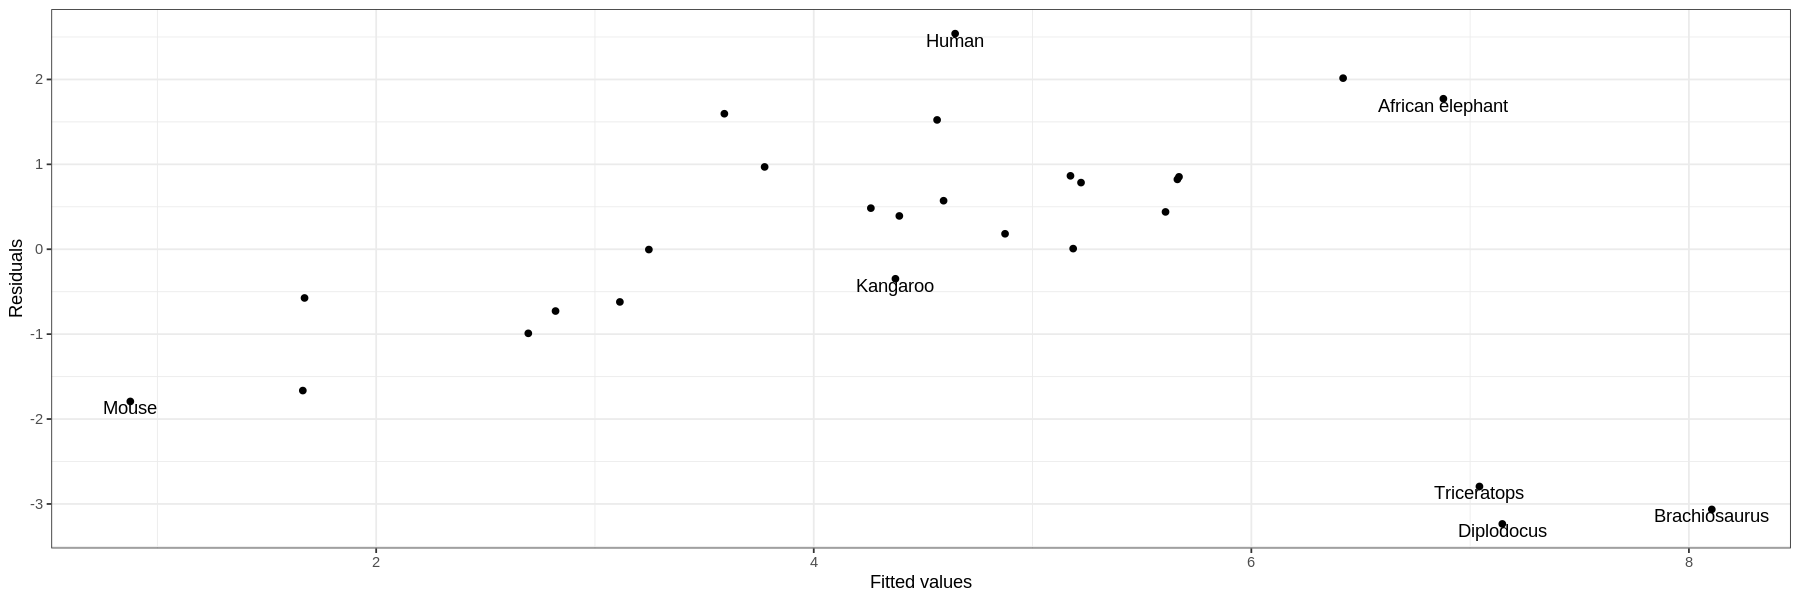

In [34]:
# Add some labels to residuals:
ggplot(bb.fort, aes(y=.resid, x=.fitted)) +
  geom_point() + theme_bw() +
  xlab("Fitted values") + ylab("Residuals") +
  geom_text(data=bb.fort %>% filter(Species %in% c("Mouse", "Kangaroo", "Human", "African elephant",
          "Triceratops", "Brachiosaurus", "Diplodocus")),
            aes(label=Species), vjust=1)


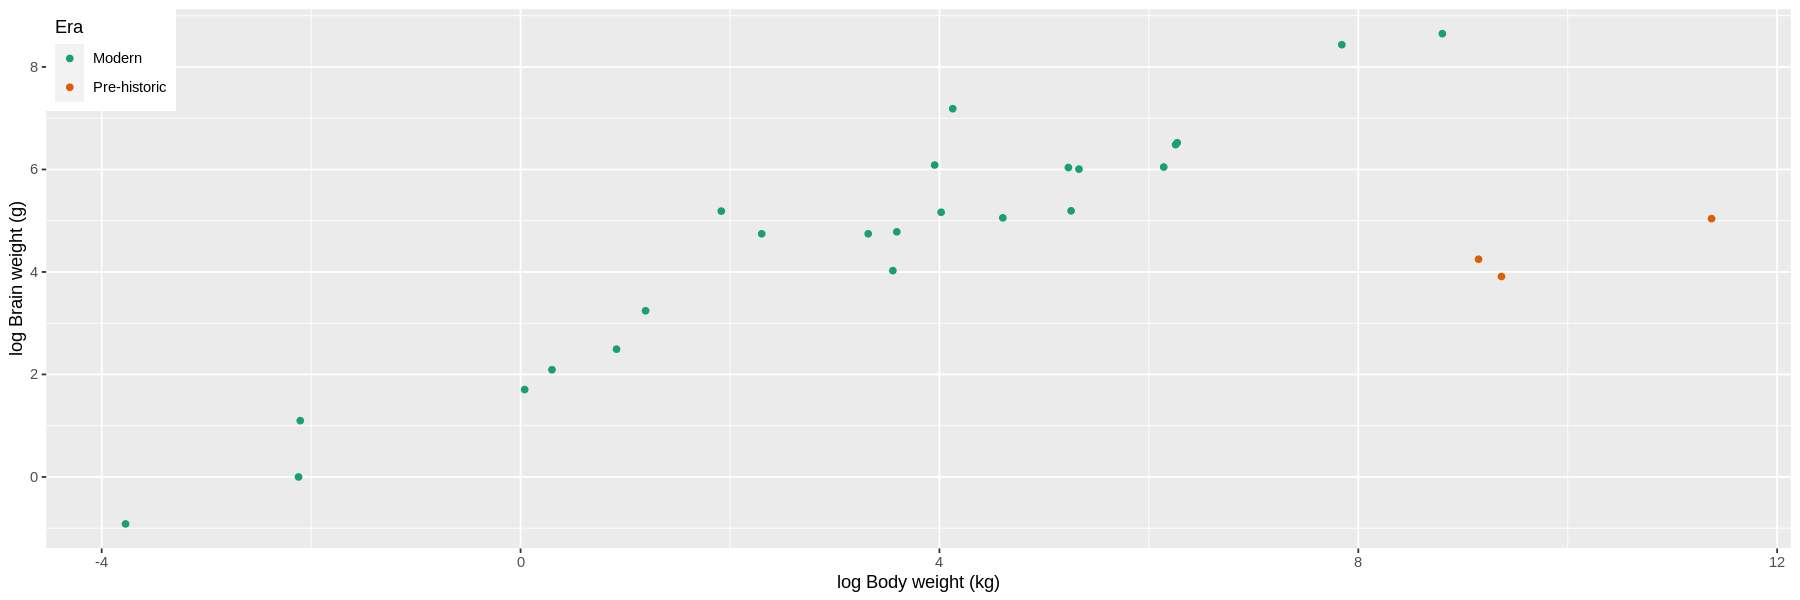

In [35]:
# Visual:
ggplot(animals, aes(x=log(Body), y=log(Brain))) +
  geom_point(aes(color=Era)) +
  xlab("log Body weight (kg)") +
  ylab("log Brain weight (g)") +
  theme(legend.position=c(0,1),
        legend.justification=c(0,1)) + scale_color_brewer(palette="Dark2")


In [36]:
# Fit era:
bb.lm.parallel <-lm(log(Brain) ~ log(Body) + Era - 1, animals)
tidy(bb.lm.parallel, conf.int=T)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
log(Body),0.7377803,0.04632325,15.926781,2.922171e-14,0.6421738,0.8333868
EraModern,2.2198146,0.20774670,10.685198,1.326578e-10,1.7910465,2.6485827
EraPre-historic,-2.9503837,0.61778876,-4.775716,7.345257e-05,-4.2254370,-1.6753304


In [37]:
# Undo our transformations:
tidy(bb.lm.parallel, conf.int=T, exponentiate = T)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
log(Body),2.09128829,0.04632325,15.926781,2.922171e-14,1.90060792,2.3010989
EraModern,9.20562404,0.20774670,10.685198,1.326578e-10,5.99572362,14.1339927
EraPre-historic,0.05231963,0.61778876,-4.775716,7.345257e-05,0.01461894,0.1872463


Extra *extra* careful here, remember our model is:
$$
y_i = e^{\beta_0} \times x_i^{\beta_1} \times e^{ \varepsilon_i }
$$

- Modern: $Brain = 9.206 \times Body^{0.738}$


- Pre-historic:  $Brain = 0.052 \times Body^{0.738}$


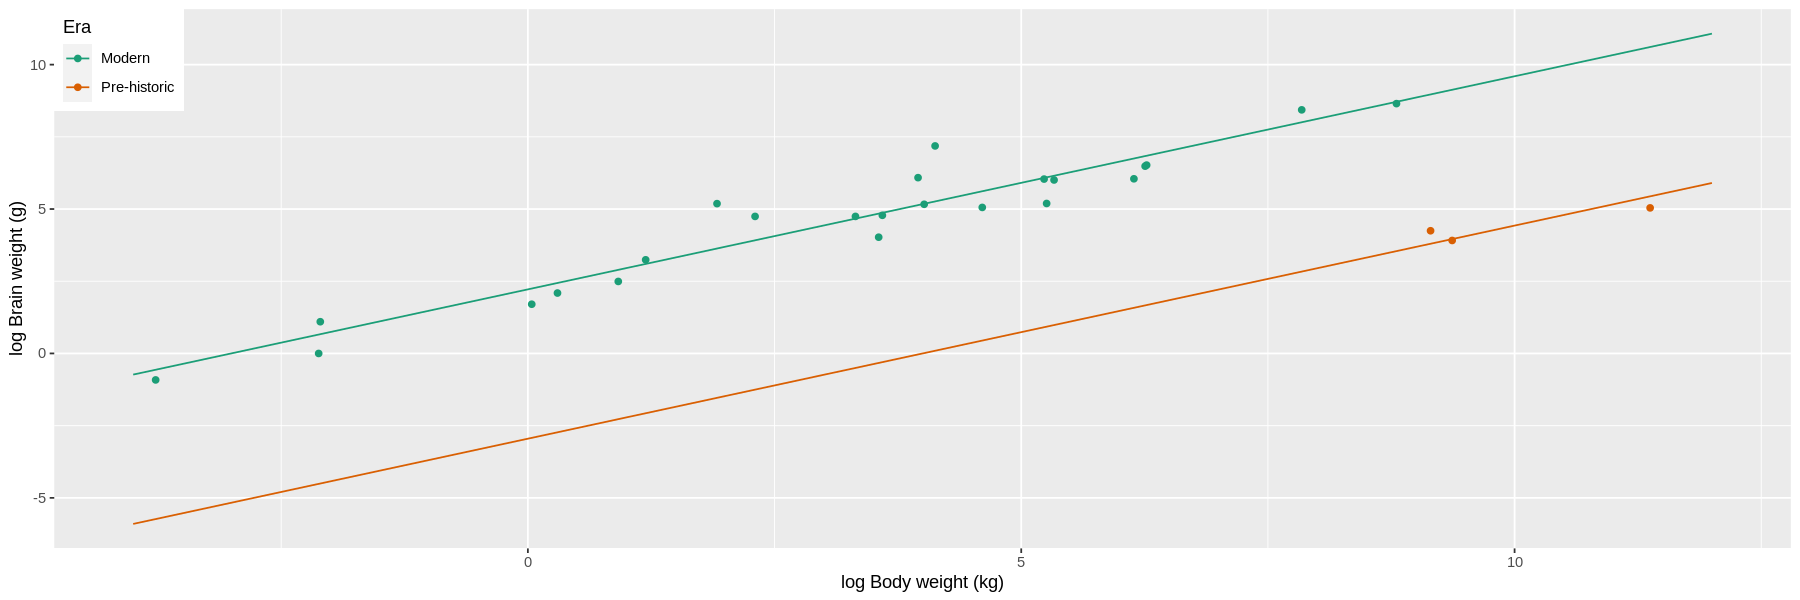

In [38]:
# Visual with model lines:
newdata <- expand.grid(Era = c("Modern", "Pre-historic"),
                       Body = exp(seq(-4, 12, by=1)))

predict(bb.lm.parallel, newdata, interval="prediction", type="response") %>%
  exp %>% # our responses are in log scale but our predictors are full scale
  data.frame %>%
  bind_cols(newdata) %>%
  ggplot(aes(color=Era, x=log(Body), y=log(fit))) +
    geom_line() +
    geom_point(data=animals, aes(y=log(Brain))) +
    xlab("log Body weight (kg)") +
    ylab("log Brain weight (g)") +
    theme(legend.position=c(0,1),
          legend.justification=c(0,1)) + scale_color_brewer(palette="Dark2")


- Can't look at model fit without intercepts...

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


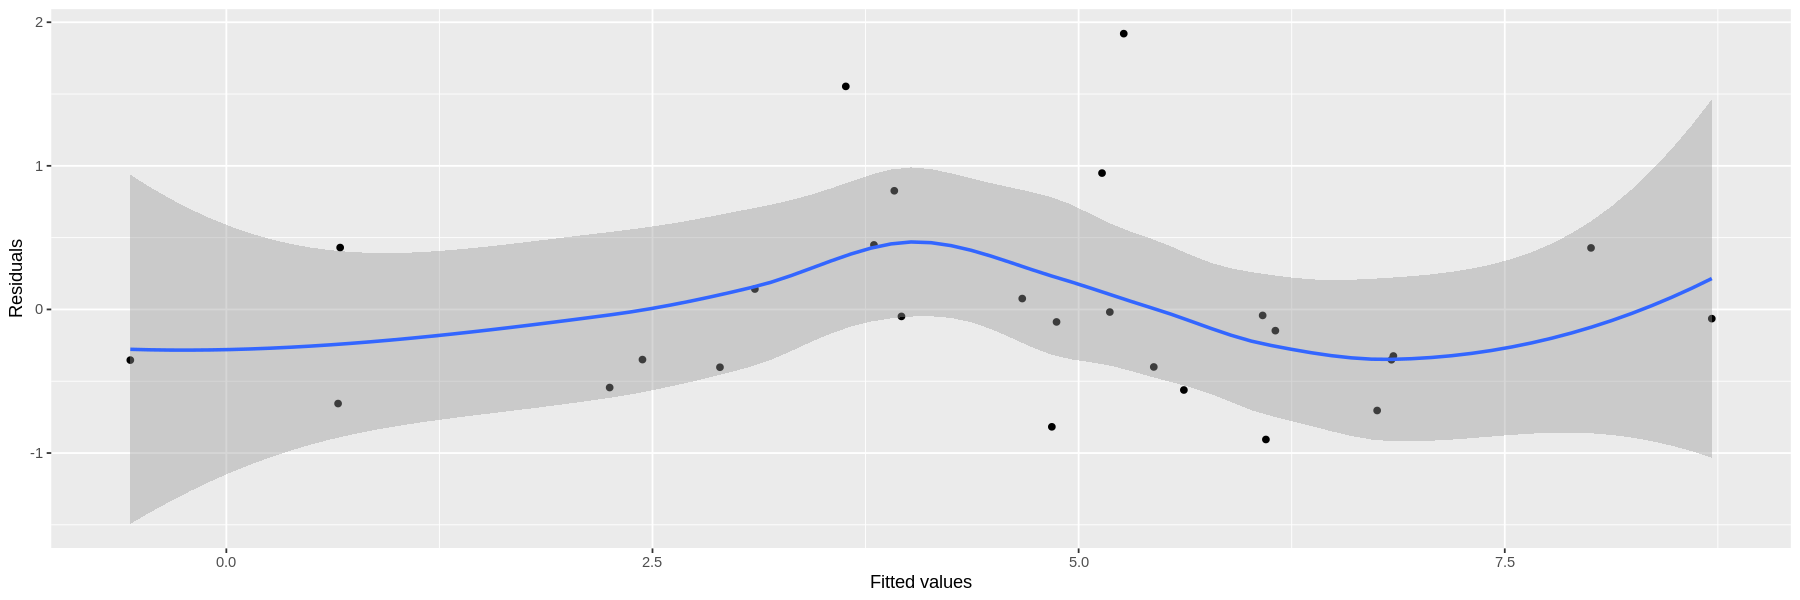

In [39]:
# Residual vs fitted:
# bb.fort.parallel <- fortify(bb.lm.parallel) %>%
  # bind_cols(animals)
bb.fort.parallel <- augment(bb.lm.parallel)
ggplot(bb.fort.parallel, aes(y=.resid, x=.fitted)) +
  geom_point() + geom_smooth() +
  xlab("Fitted values") + ylab("Residuals")


## Parallel order model

In [40]:
# Separate primates?
bb.lm.parallel3 <-lm(log(Brain) ~ log(Body) + Order - 1, animals)
tidy(bb.lm.parallel3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
log(Body),0.7290312,0.03203191,22.759528,2.838964e-17
OrderDinosaur,-2.8632148,0.42693495,-6.706443,7.678839e-07
OrderNon-primate,1.9786171,0.15069434,13.130003,3.593983e-12
OrderPrimate,3.2710666,0.24701427,13.242420,3.019761e-12


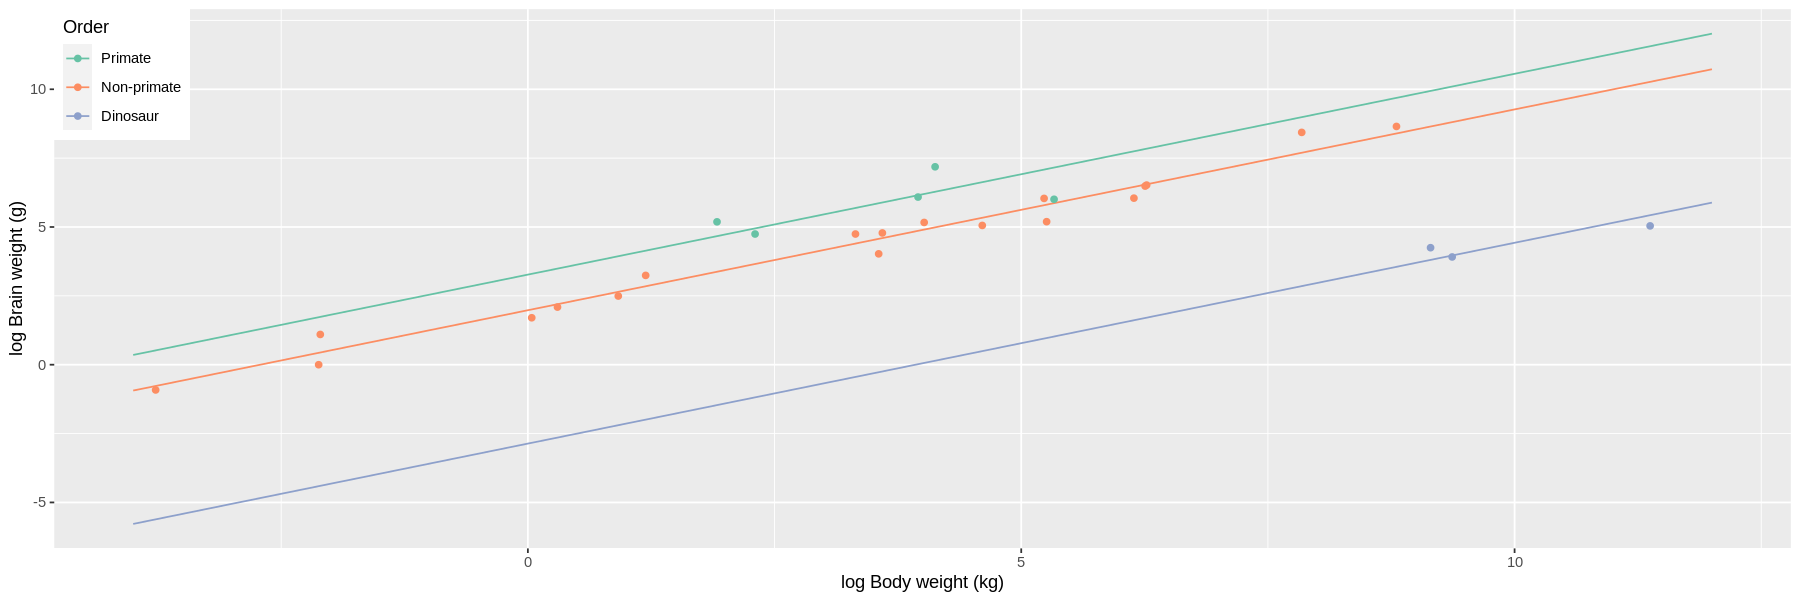

In [41]:
# Visual:
newdata <- expand.grid(Order = c("Primate", "Non-primate", "Dinosaur"),
                       Body = exp(seq(-4, 12, by=1)))

predict(bb.lm.parallel3, newdata, interval="prediction", type="response") %>%
  exp %>%
  data.frame %>%
  bind_cols(newdata) %>%
  ggplot(aes(color=Order, x=log(Body), y=log(fit))) +
    geom_line() +
    geom_point(data=animals, aes(y=log(Brain))) +
    xlab("log Body weight (kg)") +
    ylab("log Brain weight (g)") +
    theme(legend.position=c(0,1),
          legend.justification=c(0,1)) +
    scale_color_brewer(palette="Set2")


- still no intercepts...

New names:
• `Order` -> `Order...3`
• `Order` -> `Order...13`
`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


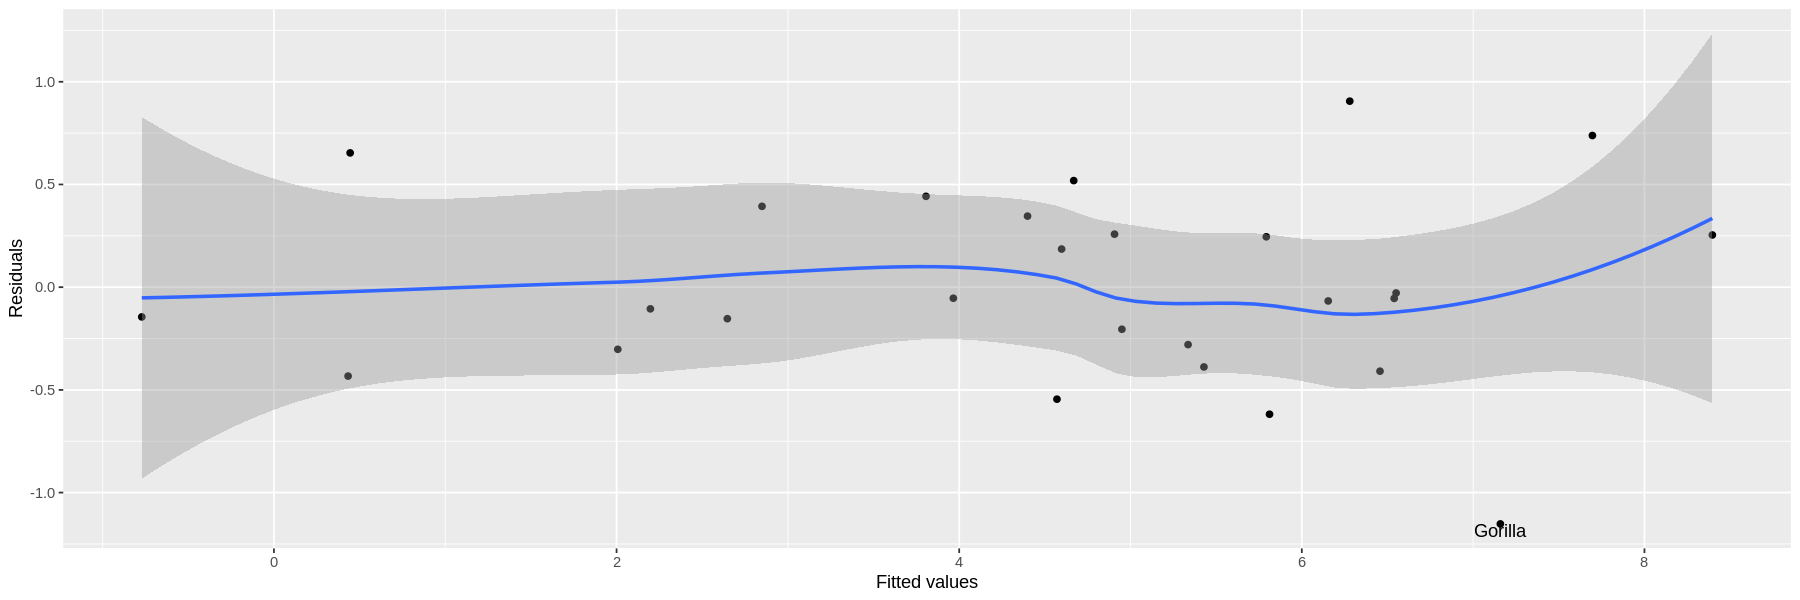

In [42]:
# Residuals vs fitted:
bb.fort.parallel3 <- bind_cols(fortify(bb.lm.parallel3), animals)

# using Species in the next plot

ggplot(bb.fort.parallel3, aes(y=.resid, x=.fitted)) +
  geom_point() + geom_smooth() +
  xlab("Fitted values") + ylab("Residuals") +
  geom_text(data=filter(bb.fort.parallel3, Species=="Gorilla"), aes(label=Species), vjust=1)


- Perhaps gorilla is now a problem.
- Don't have any more data,though. Need more evidence.
- In fact, it's hard to characterise relationship for dinosaurs given only 3 dinosaur observations.
- Was spliting modern animals into primates and non-primates worth it?

In [43]:
bb2 <- lm(log(Brain) ~ log(Body) + Era, animals)
bb3 <- lm(log(Brain) ~ log(Body) + Order, animals)

anova(bb2, bb3)


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,24,12.143293,NA,NA,NA,NA
2,23,5.549241,1,6.594052,27.33044,2.655425e-05


- From p-value, yes, grouping by `Order` is better than `Era`.
- NOTE: Might have to look hard, but these are nested models.

In [44]:
# Can consider this is a model matrix (refer to indicator/dummy variables from the
# categorical regression lecture).
# i.e., omit the intercept so that every level of the categorical variable is
# included.
head(model.matrix(bb.lm.parallel3))
head(model.matrix(bb3))
# This can help with interpretation, but remember those caveats about excluding
# intercepts.

,log(Body),OrderDinosaur,OrderNon-primate,OrderPrimate
1,0.30010459,0,1,0
2,6.14203741,0,1,0
3,3.59264385,0,1,0
4,3.31998733,0,1,0
5,0.03922071,0,1,0
6,9.36734412,1,0,0


,(Intercept),log(Body),OrderNon-primate,OrderPrimate
1,1,0.30010459,1,0
2,1,6.14203741,1,0
3,1,3.59264385,1,0
4,1,3.31998733,1,0
5,1,0.03922071,1,0
6,1,9.36734412,0,0


# Case study 3: Woods' Portland cement setting data


Need: Heat evolution of cement is an important part of its drying, as it affects
expansion while trying and therefore cracking during setting. The four primary
ingredients are tricalcium aluminate (Celite), tricalcium silicate (Alite),
tetracalciumaluminoferrite (Felite), and dicalcium silicate (Belite).

Each specific recipe (relative proportion of each ingredient) may vary, affecting
the heat evolution (calories/gram) of the cement.

Produce a model to satisfy the above need, considering (where relevant)
assumptions, polynomial models, interactions, transforms, etc.


### Intial model

In [45]:
head(MASS::cement)
cement <- MASS::cement %>% rename(`Celite` = x1,
                            `Alite` = x2,
                            `Felite` = x3,
                            `Belite` = x4,
                            `Heat` = y) %>%
  mutate(Other = 100 - (Celite + Alite + Felite + Belite))
head(cement)

,x1,x2,x3,x4,y
,<int>,<int>,<int>,<int>,<dbl>
1,7,26,6,60,78.5
2,1,29,15,52,74.3
3,11,56,8,20,104.3
4,11,31,8,47,87.6
5,7,52,6,33,95.9
6,11,55,9,22,109.2


,Celite,Alite,Felite,Belite,Heat,Other
,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,7,26,6,60,78.5,1
2,1,29,15,52,74.3,3
3,11,56,8,20,104.3,5
4,11,31,8,47,87.6,3
5,7,52,6,33,95.9,2
6,11,55,9,22,109.2,3


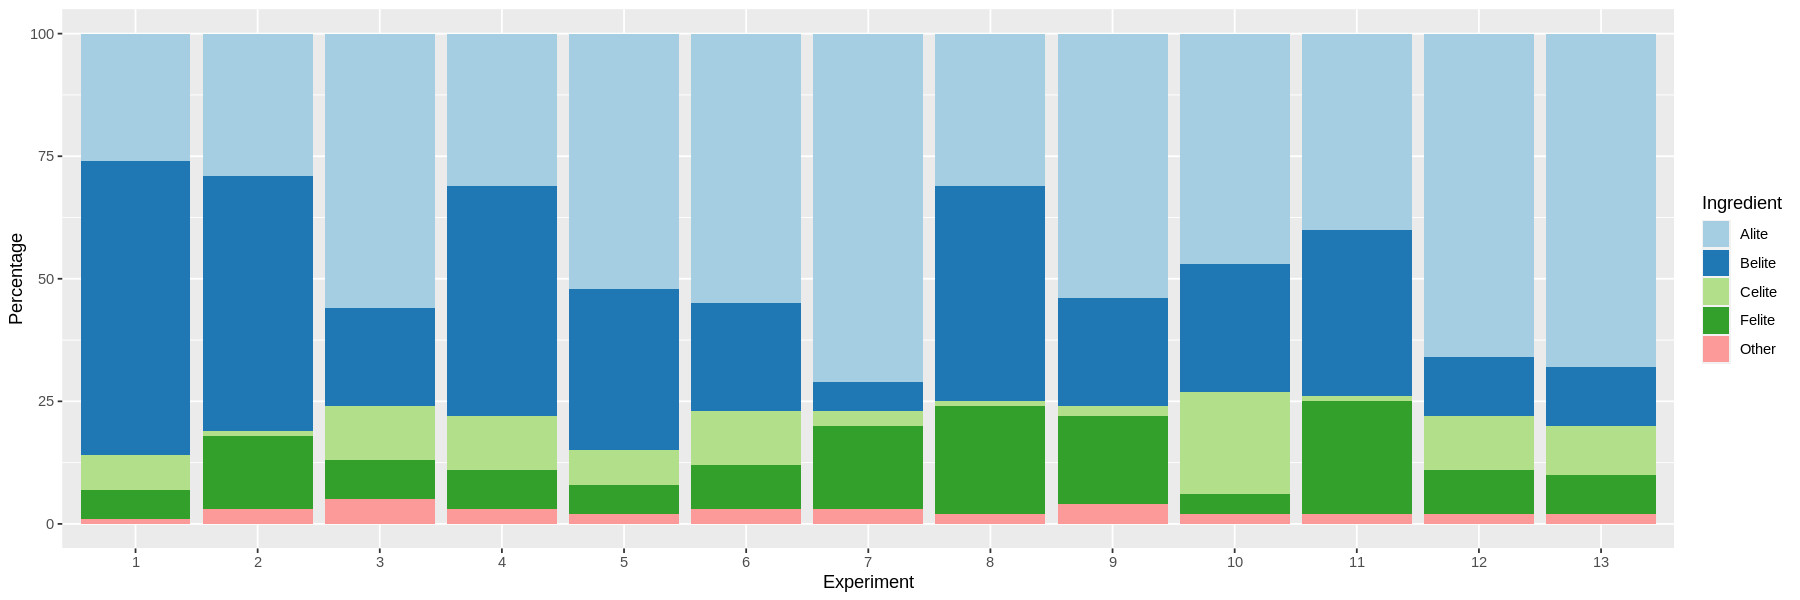

In [64]:
# Visual, by experiment:
cement %>%
  mutate(ID = seq_len(n())) %>%
  gather(Ingredient, Proportion, -c(Heat, ID)) %>%
  ggplot(aes(x = factor(ID), y = Proportion)) +
  geom_bar(stat = "identity", aes(fill = Ingredient)) +
  scale_fill_brewer(palette = "Paired") +
  xlab("Experiment") +
  ylab("Percentage")

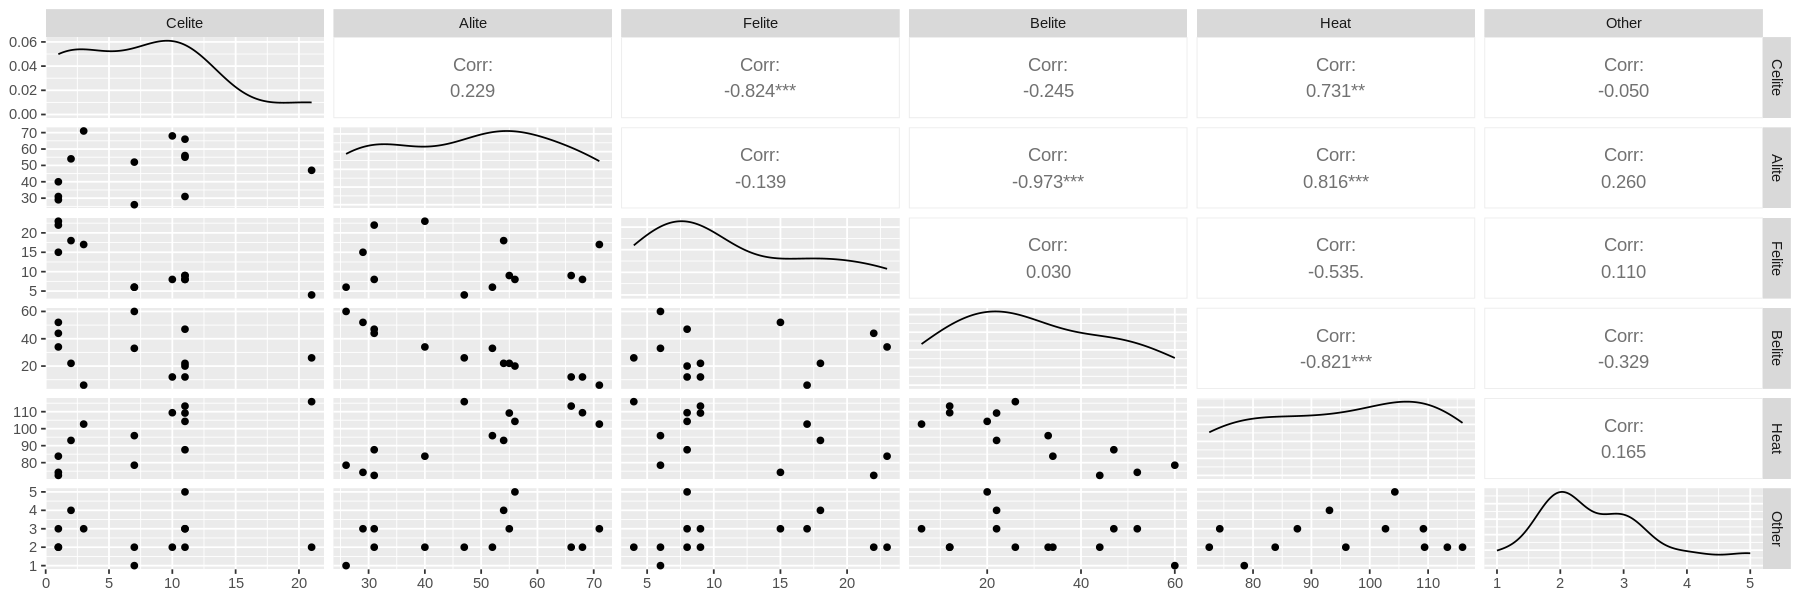

In [47]:
# Multiple explanatory variables, let's look a correlation:
# cor(cement)
ggpairs(cement)


- Correlation looks fine for all variables with Heat (except for Other).


In [48]:
# Model:
lm.portland <- lm(Heat ~ Alite + Belite + Celite + Felite, cement)
tidy(lm.portland)
glance(summary(lm.portland))



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),62.4053693,70.0709592,0.8906025,0.39913356
Alite,0.5101676,0.7237880,0.7048577,0.50090110
Belite,-0.1440610,0.7090521,-0.2031741,0.84407147
Celite,1.5511026,0.7447699,2.0826603,0.07082169
Felite,0.1019094,0.7547090,0.1350314,0.89592269


r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.9823756,0.9735634,2.446008,111.4792,4.756182e-07,4,8,13


- No variables significant despite high R-squared.
???
- Celite is close to significant, how about we just model with Celite?


### Reduced model (Celite)

In [49]:
# Fit new model:
lm.portland.C <- lm(Heat ~ Celite, cement)
tidy(lm.portland.C)
glance(summary(lm.portland.C))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),81.479344,4.9273362,16.536185,4.067067e-09
Celite,1.868748,0.5264074,3.550002,4.552045e-03


r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.533948,0.4915797,10.72672,12.60252,0.004552045,1,11,13


- R-squared is only 0.5339?
- Compare with bigger model.


In [50]:
anova(lm.portland.C, lm.portland)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,11,1265.68675,NA,NA,NA,NA
2,8,47.86364,3,1217.823,67.84959,4.956162e-06


- Bigger model definitely better. Why?
- Multicollinearity! Review correlations.


In [51]:
cor(cement)

,Celite,Alite,Felite,Belite,Heat,Other
Celite,1.00000000,0.2285795,-0.8241338,-0.2454451,0.7307175,-0.05010722
Alite,0.22857947,1.0000000,-0.1392424,-0.9729550,0.8162526,0.26044918
Felite,-0.82413376,-0.1392424,1.0000000,0.0295370,-0.5346707,0.11025122
Belite,-0.24544511,-0.9729550,0.0295370,1.0000000,-0.8213050,-0.32907694
Heat,0.73071747,0.8162526,-0.5346707,-0.8213050,1.0000000,0.16458053
Other,-0.05010722,0.2604492,0.1102512,-0.3290769,0.1645805,1.00000000


- Alite and Belite  strongly negatively correlated
- Celite and Felite strongly negatively correlated
- So perhaps we only need one from each pair, but which?


### Expanded models

In [72]:
# Run the models and compare R-squared:
results <- data.frame(
  First = rep(c("Alite", "Belite"), each = 2),
  Second = rep(c("Celite", "Felite"), times = 2)
)
results$`adj.R^2` <- lapply(seq_len(nrow(results)), function(i) {
  formula <- as.formula(glue("Heat ~ {results$First[i]} + {results$Second[i]}"))
  lm(formula, cement) %>%
    summary() %>%
    .$adj.r.squared
})
results

First,Second,adj.R^2
<chr>,<chr>,<list>
Alite,Celite,0.974414
Alite,Felite,0.8164305
Belite,Celite,0.9669653
Belite,Felite,0.9223476


- Model with Alite and Celite seems to perform best.


In [75]:
# Model:
lm.portland.2 <- lm(data=cement, Heat ~ Alite + Celite)
tidy(lm.portland.2)
glance(summary(lm.portland.2))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),52.5773489,2.28617433,22.99796,5.456571e-10
Alite,0.6622505,0.04585472,14.44236,5.028960e-08
Celite,1.4683057,0.12130092,12.10465,2.692212e-07


r.squared,adj.r.squared,sigma,statistic,p.value,df,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
0.9786784,0.974414,2.406335,229.5037,4.406579e-09,2,10,13


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


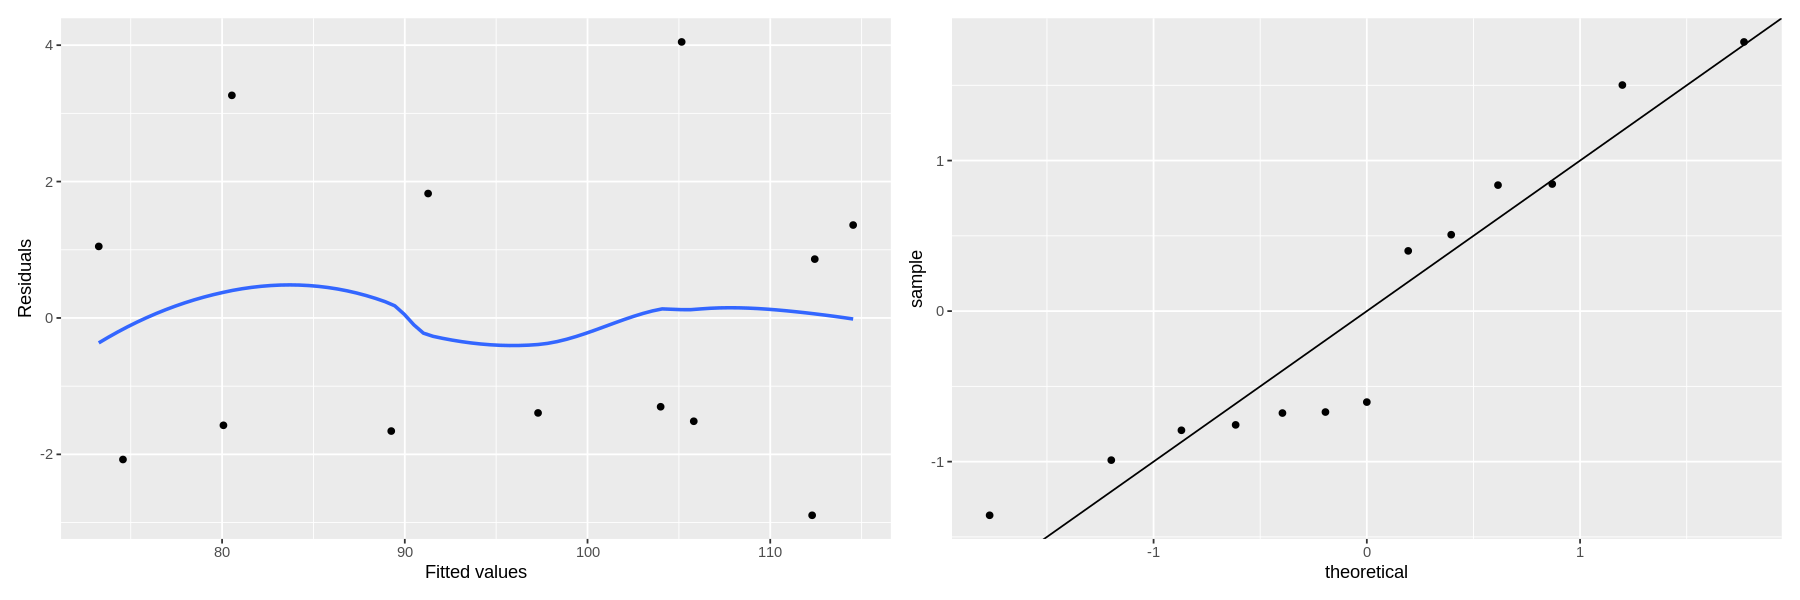

In [62]:
# Assumptions:
lm.fort.2 <- fortify(lm.portland.2)

ac1 <- ggplot(data=lm.fort.2, aes(x=.fitted, y=.resid)) +
  geom_point() + geom_smooth(se=F) +
  xlab("Fitted values") + ylab("Residuals")

ac2 <- ggplot(data=lm.fort.2, aes(sample=.stdresid)) +
  geom_point(stat="qq") +
  geom_abline()

# grid.arrange(ac1, ac2, nrow=1)
ac1 + ac2 # patchwork

- Assumptions not quite right, might be able to improve by assessing curvature in residuals.
- Check fit against explanatory variables.

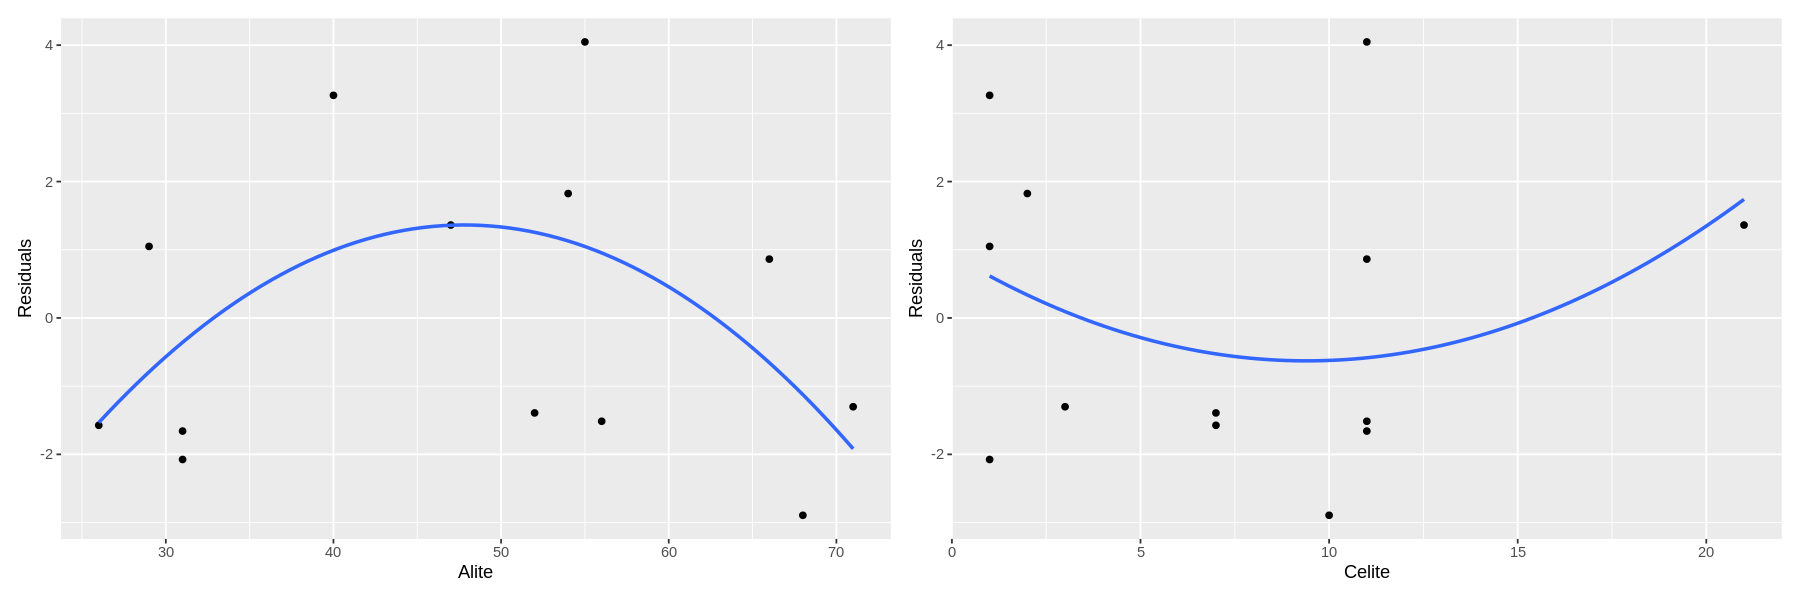

In [76]:
# fishing for polynomials...
ac3 <- ggplot(data=lm.fort.2, aes(x=Alite, y=.resid)) +
  geom_point() +
  ylab("Residuals") +
  geom_smooth(se=F, method="lm", formula = y ~ poly(x,2))


ac4 <- ggplot(data=lm.fort.2, aes(x=Celite, y=.resid)) +
  geom_point() +
  ylab("Residuals") +
  geom_smooth(se=F, method="lm", formula = y ~ poly(x,2))

# grid.arrange(ac3, ac4, nrow=1)
ac3 + ac4 # patchwork

In [55]:
# Compare quadratic models:
model1 <- lm(Heat ~ Alite + Celite, cement)
model2 <- lm(Heat ~ poly(Alite, 2) + Celite, cement)
model3 <- lm(Heat ~ Alite + poly(Celite, 2), cement)
model4 <- lm(Heat ~ poly(Alite, 2) + poly(Celite, 2), cement)

anova(model1, model2)
anova(model1, model3)
anova(model1, model4)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,57.90448,NA,NA,NA,NA
2,9,40.19461,1,17.70987,3.965427,0.07762905


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,57.90448,NA,NA,NA,NA
2,9,50.77947,1,7.125015,1.262816,0.290198


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10,57.90448,NA,NA,NA,NA
2,8,37.62509,2,20.27939,2.155943,0.1782632


- None better than the original.
- Fall back on our motto:
  >"All models are wrong, but some models are useful" - George E. P. Box
- If there's no better model, our model might still produce useful insights.

- There are more complex techniques, but this is where we leave you in MXN500.